### Predicting wood, charcoal, and other solid fuels for cooking in Mexican households

Currently, 13% of homes in Mexico cook with wood or charcoal as their primary fuel source, with 39% of homes in the four poorest states doing so. And despite being in the top 5 of GDP per capita in Latin America, Mexico trails most of the South and Central American countries in access to clean cooking fuels. What can we learn about areas in Mexico that have high use of wood or charcoal cooking that could predict which homes use wood or charcoal as their primary cooking fuel and why they haven't switched to gas or electric? Is it cultural? Economic? Something else? This is an important question as there are major health, climate, and deforestation implications for continuing to cook with biofuels.

### Understanding the Implications

Cooking with wood and charcoal has several important socioeconomic impacts on populations. First, cooking by burning solid fuels is a health hazard due to inhalation of smoke. This is a particularly acute issue for women's health. Second, the use of burning wood and charcoal can lead to deforestation, incease CO2 in the atomosphere, and increase particulate pollution locally. As the world, and Mexico, increases development and switches from solid biofuels to gas or electric cooking appliances, there is value in understanding what households use biomass cooking today, what are the main reasons those households do, and how can government incentives, utilities, and appliance companies increase utilization of other forms of cooking fuel. 

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

### Understanding the Data

This data comes from IPUMS International Mexico Census Data 2020. I have selected a data extract for 1% of population size or 1.5M individuals. This data includes household information (e.g., utilities, house size, ownership), as well as geographical information and personal demographics of individuals in the house.

In [3]:
raw_data = pd.read_csv('Data/ipumsi_00003.csv.gz')

In [5]:
raw_data.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
COUNTRY,1500909.0,4.840000e+02,0.000000e+00,4.840000e+02,4.840000e+02,4.840000e+02,4.840000e+02,4.840000e+02
YEAR,1500909.0,2.020000e+03,0.000000e+00,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03
SAMPLE,1500909.0,4.842020e+08,0.000000e+00,4.842020e+08,4.842020e+08,4.842020e+08,4.842020e+08,4.842020e+08
SERIAL,1500909.0,1.981807e+09,1.159707e+09,6.000000e+03,9.690560e+08,1.968785e+09,2.968215e+09,4.016625e+09
PERSONS,1500909.0,4.823164e+00,2.339127e+00,1.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00,2.900000e+01
HHWT,1500909.0,8.354003e+01,1.401998e+02,9.990000e+00,9.990000e+00,3.996000e+01,7.992000e+01,6.763230e+03
POPDENSGEO1,1500909.0,2.650132e+02,8.276464e+02,1.096000e+01,4.493000e+01,8.043000e+01,1.914200e+02,6.128350e+03
GEO1_MX,1500909.0,4.840181e+05,7.798928e+00,4.840010e+05,4.840120e+05,4.840180e+05,4.840230e+05,4.840320e+05
GEO2_MX,1500909.0,4.840181e+08,7.816861e+03,4.840010e+08,4.840121e+08,4.840180e+08,4.840230e+08,4.840321e+08
LOCALMX,1500909.0,8.754076e+03,2.999288e+03,1.010000e+02,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03


In [7]:
#we don't need Country, Year, or Sample since this dataset is all Mexico, 2020, and all part of the same IPUMS sample
data = raw_data.drop(columns = ['COUNTRY', 'YEAR', 'SAMPLE'])

In [9]:
data.head()

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,KITCHEN,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN
0,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,1,589.41,40,1,4,2,25000
1,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,2,589.41,41,2,4,2,25000
2,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,3,589.41,10,2,4,2,99999999
3,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,4,589.41,7,2,4,2,99999999
4,16000,5,589.41,253.08,484001,484001001,101,1,100,1,...,21,6,1,1,589.41,39,2,4,2,26000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500909 entries, 0 to 1500908
Data columns (total 28 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   SERIAL       1500909 non-null  int64  
 1   PERSONS      1500909 non-null  int64  
 2   HHWT         1500909 non-null  float64
 3   POPDENSGEO1  1500909 non-null  float64
 4   GEO1_MX      1500909 non-null  int64  
 5   GEO2_MX      1500909 non-null  int64  
 6   LOCALMX      1500909 non-null  int64  
 7   OWNERSHIP    1500909 non-null  int64  
 8   OWNERSHIPD   1500909 non-null  int64  
 9   ELECTRIC     1500909 non-null  int64  
 10  WATSUP       1500909 non-null  int64  
 11  SEWAGE       1500909 non-null  int64  
 12  FUELCOOK     1500909 non-null  int64  
 13  PHONE        1500909 non-null  int64  
 14  CELL         1500909 non-null  int64  
 15  INTERNET     1500909 non-null  int64  
 16  TRASH        1500909 non-null  int64  
 17  ROOMS        1500909 non-null  int64  
 18  KI

In [13]:
#list categorical columns
categorical_raw = ['GEO1_MX', 'GEO2_MX', 'LOCALMX', 'OWNERSHIP','OWNERSHIPD','ELECTRIC','WATSUP','SEWAGE','FUELCOOK','PHONE','CELL',
                   'INTERNET', 'TRASH','KITCHEN','HHTYPE','SEX','SPEAKIND','LIT']

In [15]:
for col in data:
    if col in categorical_raw:
        data[col] = data[col].astype('category')

In [16]:
data.head()

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,KITCHEN,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN
0,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,1,589.41,40,1,4,2,25000
1,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,2,589.41,41,2,4,2,25000
2,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,3,589.41,10,2,4,2,99999999
3,6000,4,589.41,253.08,484001,484001001,101,1,100,1,...,21,3,1,4,589.41,7,2,4,2,99999999
4,16000,5,589.41,253.08,484001,484001001,101,1,100,1,...,21,6,1,1,589.41,39,2,4,2,26000


In [17]:
#Look at age to see where to cut
data['AGE'].value_counts()

AGE
10     30690
8      30483
12     29494
4      29384
5      29061
       ...  
96       339
97       264
98       245
99       192
999       33
Name: count, Length: 102, dtype: int64

### Data Preparation

Now that I know what's in the data and how IPUMS exports their extracts, I can begin to make the data more useable for modeling, as well as more interpretable. This will mean converting numeric codes to geographic locations at the state level, mapping categorical variables to their census collected responses, reducing the different options to reduce dimensionality in the data, and finally aggregating the data by household, rather than by individual.

In [22]:
data_category = data

#convert numeric codes to categorical variables
#because I want to keep mapping regions as numbers to match to mapping data, need both columns
state_mapping = {
        484001: "Aguascalientes", 484002: "Baja California", 484003: "Baja California Sur",
        484004: "Campeche", 484005: "Coahuila de Zaragoza", 484006: "Colima", 484007: "Chiapas",
        484008: "Chihuahua", 484009: "Distrito Federal", 484010: "Durango", 484011: "Guanajuato",
        484012: "Guerrero", 484013: "Hidalgo", 484014: "Jalisco", 484015: "México",
        484016: "Michoacán de Ocampo", 484017: "Morelos", 484018: "Nayarit", 484019: "Nuevo León",
        484020: "Oaxaca", 484021: "Puebla", 484022: "Querétaro", 484023: "Quintana Roo",
        484024: "San Luis Potosí", 484025: "Sinaloa", 484026: "Sonora", 484027: "Tabasco",
        484028: "Tamaulipas", 484029: "Tlaxcala", 484030: "Veracruz de Ignacio de la Llave",
        484031: "Yucatán", 484032: "Zacatecas"
}
data_category['STATE_NAME'] = data['GEO1_MX'].map(state_mapping)

#the rest of the easy to map categorical columns can be mapped here
other_category_mappings = {
    "OWNERSHIP": {0: "NIU", 1: "Owned", 2: "Not owned", 9: "Unknown"},
    "ELECTRIC": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "PHONE": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "CELL": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "INTERNET": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "SEX": {1: "Male", 2: "Female", 9: "Unknown"},
    "HHTYPE": {0: "Vacant household", 1: "One-person household", 2: "Married/cohab couple, no children", 
               3: "Married/cohab couple with children", 4: "Single-parent family", 5: "Polygamous family", 
               6: "Extended family, relatives only", 7: "Composite household, family and non-relatives", 8: "Non-family household", 
               9: "Unclassified subfamily", 10: "Other relative or non-relative household", 11: "Group quarters", 99: "Unclassifiable"},
    "LIT": {0: "NIU", 1: "No, illiterate", 2: "Yes, literate", 9: "Unknown"},
    "SEWAGE": {00: "NIU", 10: "Connected to sewage system or septic", 11:"Sewage system", 12: "Septic tank", 20: "Not connected", 99: "Unknown"},
    "SPEAKIND": {0: "NIU", 1: "Yes", 2: "Yes", 3: "Yes", 4: "No", 8: "Does not speak", 9: "Unknown"}
}

# Apply mappings to categorical columns
for col, mapping in other_category_mappings.items():
    if col in data.columns:
        data_category[col] = data[col].map(mapping)

#there are other harder to map categorical columns that must be simplified
def map_water_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10,11,12,13]:
        return 'Piped, in home'
    elif value in [14,15,16,17,18]:
        return 'Piped access'
    elif value in [20]:
        return 'No piped access'
    else:
        return 'Unknown'

data_category['WATSUP'] = data['WATSUP'].apply(map_water_type)

def map_trash_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10, 11,12,13,14]:
        return 'Collected'
    elif value in [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]:
        return 'Burned, burried, or dumped'
    elif value in [35,36,37,38]:
        return 'Fed to animals, composted, or heaped'
    elif value in [39]:
        return 'Other'
    else:
        return 'Unknown'

data_category['TRASH'] = data['TRASH'].apply(map_trash_type)

def map_kitchen_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10,11,13]:
        return 'No kitchen'
    elif value in [20,21,22,23,24,25]:
        return 'Indoor kitchen'
    elif value in [26,27,28]:
        return 'Outdoor kitchen'
    else:
        return 'Unknown'

data_category['KITCHEN'] = data['KITCHEN'].apply(map_kitchen_type)

def map_fuel_type(value):
    if value in [00]:
        return 'NIU'
    elif value in [10]:
        return 'None'
    elif value in [20]:
        return 'Electric'
    elif value in [30,31,32,33,34,35]:
        return 'Petroleum gas (NG, propane, or other)'
    elif value in [40,41,42,43,44,45,46,47]:
        return 'Petroleum liquid (gasoline, diesel, keorsene)'
    elif value in [50,51,52,53,54,55,56,73,74,75]:
        return 'Wood, charcoal, coal, or other burned biomaterial'
    elif value in [70,71,72,76,77]:
        return 'Other (solar, alcohol, etc.)'
    else:
        return 'Unknown'

data_category['FUELCOOK'] = data['FUELCOOK'].apply(map_fuel_type)

data_category.head(30)

,SERIAL,PERSONS,HHWT,POPDENSGEO1,GEO1_MX,GEO2_MX,LOCALMX,OWNERSHIP,OWNERSHIPD,ELECTRIC,...,HHTYPE,NFAMS,PERNUM,PERWT,AGE,SEX,SPEAKIND,LIT,INCEARN,STATE_NAME
0,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,1,589.41,40,Male,No,"Yes, literate",25000,Aguascalientes
1,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,2,589.41,41,Female,No,"Yes, literate",25000,Aguascalientes
2,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,3,589.41,10,Female,No,"Yes, literate",99999999,Aguascalientes
3,6000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,4,589.41,7,Female,No,"Yes, literate",99999999,Aguascalientes
4,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,1,589.41,39,Female,No,"Yes, literate",26000,Aguascalientes
5,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,2,589.41,82,Male,No,"Yes, literate",99999999,Aguascalientes
6,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,3,589.41,72,Female,No,"Yes, literate",99999999,Aguascalientes
7,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,4,589.41,10,Female,No,"Yes, literate",99999999,Aguascalientes
8,16000,5,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,"Extended family, relatives only",1,5,589.41,17,Male,No,"Yes, literate",99999999,Aguascalientes
9,26000,4,589.41,253.08,484001,484001001,101,Owned,100,Yes,...,Married/cohab couple with children,1,1,589.41,23,Male,No,"Yes, literate",10750,Aguascalientes


In [23]:
data_category.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,1500909.0,NaN,NaN,NaN,1981807478.641943,1159707041.20291,6000.0,969056000.0,1968785000.0,2968215000.0,4016625000.0
PERSONS,1500909.0,NaN,NaN,NaN,4.823164,2.339127,1.0,3.0,4.0,6.0,29.0
HHWT,1500909.0,NaN,NaN,NaN,83.540027,140.199763,9.99,9.99,39.96,79.92,6763.23
POPDENSGEO1,1500909.0,NaN,NaN,NaN,265.013182,827.646435,10.96,44.93,80.43,191.42,6128.35
GEO1_MX,1500909.0,32.0,484020.0,194246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEO2_MX,1500909.0,2325.0,484009001.0,16285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOCALMX,1500909.0,233.0,9999.0,1278429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,1500909,4,Owned,1176854,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIPD,1500909.0,6.0,100.0,1176854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,1500909,4,Yes,1471215,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I now have all the data categorized how I want it to be and can see we have our categorical variables renamed. First flag here is that over 50% of the earned income values are not found or are unknown which may prove difficult for the analysis.

In [26]:
#to make everything more readable, relabel all columns
data_category = data_category.rename(columns = {
    'OWNERSHIPD': 'DETAILEDOWNERSHIP',
    'WATSUP': 'WATERSUPPLY',
    'FUELCOOK': 'COOKINGFUEL',
    'ROOMS': 'NUMROOMS',
    'NFAMS': 'NUMFAMILIES',
    'BPLCOUNTRY': 'BIRTHCOUNTRY',
    'LIT': 'LITERACY',
    'INCEARN': 'EARNEDINCOME'
})

In [27]:
data_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500909 entries, 0 to 1500908
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   SERIAL             1500909 non-null  int64   
 1   PERSONS            1500909 non-null  int64   
 2   HHWT               1500909 non-null  float64 
 3   POPDENSGEO1        1500909 non-null  float64 
 4   GEO1_MX            1500909 non-null  category
 5   GEO2_MX            1500909 non-null  category
 6   LOCALMX            1500909 non-null  category
 7   OWNERSHIP          1500909 non-null  category
 8   DETAILEDOWNERSHIP  1500909 non-null  category
 9   ELECTRIC           1500909 non-null  category
 10  WATERSUPPLY        1500909 non-null  category
 11  SEWAGE             1500909 non-null  category
 12  COOKINGFUEL        1500909 non-null  category
 13  PHONE              1500909 non-null  category
 14  CELL               1500909 non-null  category
 15  INTERNET       

In [31]:
#first look at the data to understand where there are unknowns and NIU
for feature in data_category.columns:
    print(data_category[feature].value_counts(normalize = True))

SERIAL
1384560000    1.932162e-05
910225000     1.865536e-05
1919704000    1.798910e-05
2400094000    1.798910e-05
3030193000    1.665657e-05
                  ...     
3500292000    6.662629e-07
1120554000    6.662629e-07
1120584000    6.662629e-07
1120594000    6.662629e-07
1693341000    6.662629e-07
Name: proportion, Length: 402065, dtype: float64
PERSONS
4     0.222732
5     0.192760
3     0.152448
6     0.120831
2     0.098384
7     0.072248
8     0.042598
1     0.031416
9     0.025203
10    0.016004
11    0.009300
12    0.006172
13    0.003534
14    0.002257
15    0.001399
16    0.000800
17    0.000680
18    0.000360
19    0.000228
20    0.000173
21    0.000154
22    0.000088
23    0.000061
25    0.000050
24    0.000048
27    0.000036
29    0.000019
28    0.000019
Name: proportion, dtype: float64
HHWT
9.99       2.634257e-01
29.97      1.243340e-01
39.96      1.061403e-01
19.98      1.057992e-01
49.95      6.826463e-02
               ...     
2247.75    1.332526e-06
3896.10    6.

At first look, it appears NIU and Unknowns are very small, which is good - these values can be eliminated from the dataset where they exist. The next step is to aggregate the data by household - this means finding total household income and keeping household information. <br>
<br>
It also appears that there may be some overweighting for location (e.g., Oaxaca is overrepresented in this dataset and Mexico state population is not the highest). There are also some features that do not give much information that can be eliminated, such as Locality.<br>
<br>
However, it appears income is unknown for 63% of individuals in the dataset, I will likely need to eliminate these populations unless there are other demographics that are key in determining wood fuel use.

In [34]:
#Create new dataset that is just households. Need to find total household income, keep variables like size, location, etc.
#variables that will change with household roll-up: age, person weight, age, sex, language, Literacy, Income

#first remove the columns we don't need for household roll-up or first pass regression
data_household_raw = data_category.drop(columns = ['PERWT','LOCALMX','DETAILEDOWNERSHIP','POPDENSGEO1','PERNUM','GEO1_MX'])

In [36]:
#double check which numbers are consistent across households by sampling random households
data_household_raw[data_household_raw['SERIAL'] == 6000].T

,0,1,2,3
SERIAL,6000,6000,6000,6000
PERSONS,4,4,4,4
HHWT,589.41,589.41,589.41,589.41
GEO2_MX,484001001,484001001,484001001,484001001
OWNERSHIP,Owned,Owned,Owned,Owned
ELECTRIC,Yes,Yes,Yes,Yes
WATERSUPPLY,"Piped, in home","Piped, in home","Piped, in home","Piped, in home"
SEWAGE,Sewage system,Sewage system,Sewage system,Sewage system
COOKINGFUEL,"Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)","Petroleum gas (NG, propane, or other)"
PHONE,Yes,Yes,Yes,Yes


Given that everything remains consistent ex;cept Age, sex, language spoken, literacy, and income, I will take the first value of each household for all properties, and then aggregate the remaining values (e.g., how many M and F in each household, total income, if someone speaks an indigenous language, # of children)

In [39]:
#create the aggregation rules for the groupby function
agg_rules = {
    'PERSONS': 'first',
    'HHWT': 'first',
    'GEO2_MX': 'first',
    'OWNERSHIP': 'first',
    'ELECTRIC': 'first',
    'WATERSUPPLY': 'first',
    'SEWAGE': 'first',
    'COOKINGFUEL': 'first',
    'PHONE': 'first',
    'CELL': 'first',
    'INTERNET': 'first',
    'TRASH': 'first',
    'NUMROOMS': 'first',
    'KITCHEN': 'first',
    'HHTYPE': 'first',
    'NUMFAMILIES': 'first',
    'AGE': [
        ('CHILDREN', lambda x: (x < 18).sum()),
        ('OLDER_ADULTS', lambda x: (x >= 60).sum()),
        #look at the average age for the population in case that is a factor in wood fuel use
        ('AVG_AGE_ADULTS', lambda x: x[(x > 18) & (x < 100)].mean())
    ],
    'SEX': [
        ('MALE_COUNT', lambda x: (x == 'Male').sum()),
        ('FEMALE_COUNT', lambda x: (x == 'Female').sum())
    ],
    'SPEAKIND': lambda x: 1 if (x == 'Yes').any() else 0,
    'LITERACY': lambda x: 1 if (x == 'No, illiterate').any() else 0,
    'EARNEDINCOME': lambda x: 'Unknown' if (x == 99999998).all() else x[x < 99999998].sum(),
    'STATE_NAME': 'first'
}

In [41]:
data_HH = data_household_raw.groupby('SERIAL').agg(agg_rules).reset_index()

In [42]:
data_HH

SERIAL PERSONS    HHWT    GEO2_MX  OWNERSHIP ELECTRIC  \
                     first   first      first      first    first   
0             6000       4  589.41  484001001      Owned      Yes   
1            16000       5  589.41  484001001      Owned      Yes   
2            26000       4  589.41  484001001      Owned      Yes   
3            36000       5  589.41  484001001      Owned      Yes   
4            46000       5  589.41  484001001  Not owned      Yes   
...            ...     ...     ...        ...        ...      ...   
402060  4016585000       2    9.99  484032004      Owned      Yes   
402061  4016595000       1    9.99  484032004      Owned      Yes   
402062  4016605000       3    9.99  484032004  Not owned      Yes   
402063  4016615000       2    9.99  484032004      Owned      Yes   
402064  4016625000       2    9.99  484032004      Owned      Yes   

            WATERSUPPLY         SEWAGE  \
                  first          first   
0        Piped, in home  Sewage system   
1        Piped, in home  Sewage system   
2        Piped, in home  Sewage system   
3        Piped, in home  Sewage system   
4        Piped, in home  Sewage system   
...                 ...            ...   
402060   Piped, in home  Not connected   
402061   Piped, in home    Septic tank   
402062     Piped access    Septic tank   
402063     Piped access    Septic tank   
402064  No piped access  Not connected   

                                              COOKINGFUEL PHONE  ...  \
                                                    first first  ...   
0                   Petroleum gas (NG, propane, or other)   Yes  ...   
1                   Petroleum gas (NG, propane, or other)   Yes  ...   
2                   Petroleum gas (NG, propane, or other)    No  ...   
3                   Petroleum gas (NG, propane, or other)    No  ...   
4                   Petroleum gas (NG, propane, or other)    No  ...   
...                                                   ...   ...  ...   
402060              Petroleum gas (NG, propane, or other)    No  ...   
402061  Wood, charcoal, coal, or other burned biomaterial    No  ...   
402062              Petroleum gas (NG, propane, or other)    No  ...   
402063  Wood, charcoal, coal, or other burned biomaterial    No  ...   
402064  Wood, charcoal, coal, or other burned biomaterial    No  ...   

       NUMFAMILIES      AGE                                    SEX  \
             first CHILDREN OLDER_ADULTS AVG_AGE_ADULTS MALE_COUNT   
0                1        2            0      40.500000          1   
1                1        2            2      64.333333          2   
2                1        2            0      23.500000          3   
3                1        3            0      39.500000          2   
4                1        3            0      24.500000          2   
...            ...      ...          ...            ...        ...   
402060           1        0            2      91.500000          1   
402061           1        0            1      85.000000          1   
402062           1        1            0      45.500000          2   
402063           1        0            2      77.500000          1   
402064           1        0            0      49.500000          1   

                    SPEAKIND LITERACY EARNEDINCOME      STATE_NAME  
       FEMALE_COUNT <lambda> <lambda>     <lambda>           first  
0                 3        0        0        50000  Aguascalientes  
1                 3        0        0        26000  Aguascalientes  
2                 1        0        0        10750  Aguascalientes  
3                 3        0        1        14160  Aguascalientes  
4                 3        0        1        13760  Aguascalientes  
...             ...      ...      ...          ...             ...  
402060            1        0        0            0       Zacatecas  
402061            0        0        0            0       Zacatecas  
402062            1        0 

In [43]:
#remove the second order column names
data_HH.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in data_HH.columns]

In [44]:
data_HH = data_HH.rename(columns = {
    'PERSONS_first': 'PERSONS',
    'HHWT_first': 'HHWT',
    'NUMROOMS_first': 'NUMROOMS',
    'GEO2_MX_first': 'GEO2_MX',
    'OWNERSHIP_first': 'OWNERSHIP',
    'WATERSUPPLY_first': 'WATERSUPPLY',
    'SEWAGE_first': 'SEWAGE',
    'COOKINGFUEL_first': 'COOKINGFUEL',
    'ELECTRIC_first': 'ELECTRIC',
    'PHONE_first': 'PHONE',
    'CELL_first': 'CELL',
    'INTERNET_first': 'INTERNET',
    'TRASH_first': 'TRASH',
    'KITCHEN_first': 'KITCHEN',
    'NUMFAMILIES_first': 'NUMFAMILIES',
    'HHTYPE_first': 'HHTYPE',
    'AGE_CHILDREN': 'CHILDREN',
    'AGE_OLDER_ADULTS': 'OLDER_ADULTS',
    'AGE_AVG_AGE_ADULTS': 'AVG_AGE_ADULTS',
    'SEX_MALE_COUNT': 'MALE_COUNT',
    'SEX_FEMALE_COUNT': 'FEMALE_COUNT',
    'SPEAKIND_<lambda>': 'SPEAKIND',
    'LITERACY_<lambda>': 'ANY ILLITERACY',
    'EARNEDINCOME_<lambda>': 'HHINCOME',
    'STATE_NAME_first': 'STATE_NAME'
})

In [45]:
data_HH.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,402065.0,NaN,NaN,NaN,2008315675.015234,1159502460.150636,6000.0,1004161000.0,2008316000.0,3012471000.0,4016625000.0
PERSONS,402065.0,NaN,NaN,NaN,3.733001,2.017323,1.0,2.0,4.0,5.0,29.0
HHWT,402065.0,NaN,NaN,NaN,87.005566,144.127524,9.99,19.98,39.96,79.92,6763.23
GEO2_MX,402065.0,2325.0,484009001.0,5122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,402065,4,Owned,305872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,402065,4,Yes,393274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATERSUPPLY,402065,5,"Piped, in home",229679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEWAGE,402065,5,Sewage system,233756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COOKINGFUEL,402065,7,"Petroleum gas (NG, propane, or other)",255720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHONE,402065,4,No,310559,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now there are 400K households of data from 15M people, but there is still cleaning that needs to happpen with numerical data. For example, NUMROOMS values of 99 mean 'unknown'. There's also something to be looked at with income since there were so many Unknown and 0 values.

In [47]:
#relabel NUMROOMS >97 to unknown
data_HH['NUMROOMS'] = data_HH['NUMROOMS'].apply(lambda x: 'Unknown' if x > 97 else x)

In [48]:
data_HH[data_HH['HHINCOME']=='Unknown']['HHINCOME'].value_counts()

HHINCOME
Unknown    144
Name: count, dtype: int64

In [49]:
#can now remove the Unknowns and NIU since they are both <0.5% of data in all categories
data_HH_clean = data_HH.replace(['NIU', 'Unknown'], np.nan)
data_HH_clean = data_HH_clean.dropna()
data_HH_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399089 entries, 0 to 402064
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   SERIAL          399089 non-null  int64   
 1   PERSONS         399089 non-null  int64   
 2   HHWT            399089 non-null  float64 
 3   GEO2_MX         399089 non-null  category
 4   OWNERSHIP       399089 non-null  category
 5   ELECTRIC        399089 non-null  category
 6   WATERSUPPLY     399089 non-null  category
 7   SEWAGE          399089 non-null  category
 8   COOKINGFUEL     399089 non-null  category
 9   PHONE           399089 non-null  category
 10  CELL            399089 non-null  category
 11  INTERNET        399089 non-null  category
 12  TRASH           399089 non-null  object  
 13  NUMROOMS        399089 non-null  float64 
 14  KITCHEN         399089 non-null  category
 15  HHTYPE          399089 non-null  category
 16  NUMFAMILIES     399089 non-null  int64   
 

Lost 3,000 houses or 0.5% of the data

In [51]:
for feature in ['OWNERSHIP','ELECTRIC','WATERSUPPLY','SEWAGE','COOKINGFUEL','PHONE','CELL','INTERNET','TRASH','NUMROOMS',
                'KITCHEN','HHTYPE','SPEAKIND','HHINCOME','ANY ILLITERACY','CHILDREN','OLDER_ADULTS','MALE_COUNT','FEMALE_COUNT']:
    print(data_HH_clean[feature].value_counts())

OWNERSHIP
Owned        305017
Not owned     94072
Name: count, dtype: int64
ELECTRIC
Yes    391702
No       7387
Name: count, dtype: int64
WATERSUPPLY
Piped, in home     228912
Piped access       142127
No piped access     28050
Name: count, dtype: int64
SEWAGE
Sewage system    232857
Septic tank      108485
Not connected     57747
Name: count, dtype: int64
COOKINGFUEL
Petroleum gas (NG, propane, or other)                254988
Wood, charcoal, coal, or other burned biomaterial    133832
None                                                   7214
Electric                                               2999
Other (solar, alcohol, etc.)                             56
Name: count, dtype: int64
PHONE
No     309159
Yes     89930
Name: count, dtype: int64
CELL
Yes    308681
No      90408
Name: count, dtype: int64
INTERNET
No     264475
Yes    134614
Name: count, dtype: int64
TRASH
Collected                     289916
Burned, burried, or dumped    109173
Name: count, dtype: int64
NUMROOMS
3.0  

Now that I have the data I want to make cuts on, I also want to separate out cooking fuels to be either wood/charcoal/coal or other cooking fuels so that I can decide if I want to do predictive modeling on all types of fuel or on just wood and biomass vs. not.

In [53]:
data_HH_clean['WOOD_CHARCOAL_FUEL'] = data_HH_clean['COOKINGFUEL'].isin(['Wood, charcoal, coal, or other burned biomaterial']).astype(int)
data_HH_clean

,SERIAL,PERSONS,HHWT,GEO2_MX,OWNERSHIP,ELECTRIC,WATERSUPPLY,SEWAGE,COOKINGFUEL,PHONE,...,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,ANY ILLITERACY,HHINCOME,STATE_NAME,WOOD_CHARCOAL_FUEL
0,6000,4,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,2,0,40.500000,1,3,0,0,50000.0,Aguascalientes,0
1,16000,5,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,2,2,64.333333,2,3,0,0,26000.0,Aguascalientes,0
2,26000,4,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,2,0,23.500000,3,1,0,0,10750.0,Aguascalientes,0
3,36000,5,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,3,0,39.500000,2,3,0,1,14160.0,Aguascalientes,0
4,46000,5,589.41,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,3,0,24.500000,2,3,0,1,13760.0,Aguascalientes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402060,4016585000,2,9.99,484032004,Owned,Yes,"Piped, in home",Not connected,"Petroleum gas (NG, propane, or other)",No,...,0,2,91.500000,1,1,0,0,0.0,Zacatecas,0
402061,4016595000,1,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,0,1,85.000000,1,0,0,0,0.0,Zacatecas,1
402062,4016605000,3,9.99,484032004,Not owned,Yes,Piped access,Septic tank,"Petroleum gas (NG, propane, or other)",No,...,1,0,45.500000,2,1,0,0,5160.0,Zacatecas,0
402063,4016615000,2,9.99,484032004,Owned,Yes,Piped access,Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,0,2,77.500000,1,1,0,0,0.0,Zacatecas,1


In [54]:
#determine proportion of households by state that use wood as primary means of cooking fuel
#this is a benchmark to ensure the data is fairly representative
wood_fuel_by_state = (
    data_HH_clean.groupby('STATE_NAME')
    .apply(lambda x: (x['WOOD_CHARCOAL_FUEL'] * x['HHWT']).sum() / x['HHWT'].sum())
    .reset_index(name = 'PERCENT_WOOD_FUEL').sort_values(by='PERCENT_WOOD_FUEL',ascending=False)
)
wood_fuel_by_state

,STATE_NAME,PERCENT_WOOD_FUEL
6,Chiapas,0.495905
19,Oaxaca,0.457437
11,Guerrero,0.411124
30,Yucatán,0.278059
26,Tabasco,0.270986
29,Veracruz de Ignacio de la Llave,0.251595
3,Campeche,0.238028
20,Puebla,0.212715
23,San Luis Potosí,0.198137
12,Hidalgo,0.192670


50% of households in Chiapas and Oaxaca use wood burning stoves, so I'm assuming states, and local jurisdictions, will have a large impact on whether a house has wood as the primary cooking fuel

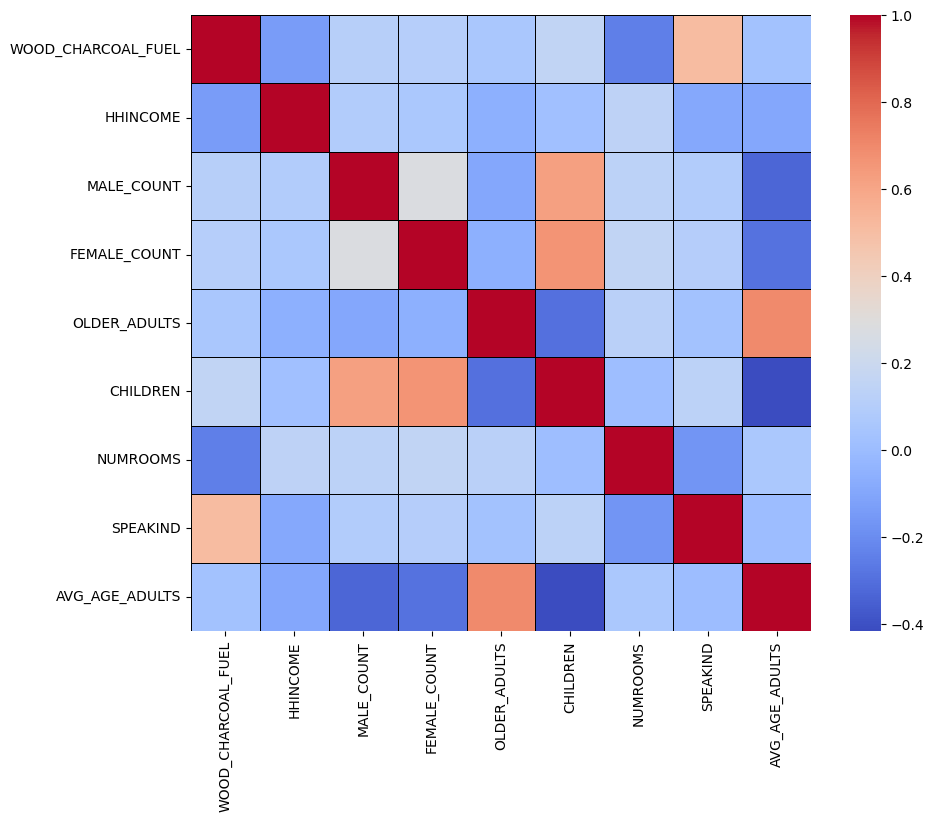

In [56]:
#couple data cuts to see what we expect
corr_variables = ['WOOD_CHARCOAL_FUEL', 'HHINCOME','MALE_COUNT','FEMALE_COUNT','OLDER_ADULTS','CHILDREN','NUMROOMS','SPEAKIND', 'AVG_AGE_ADULTS']
corr_data_HH = data_HH_clean[corr_variables].copy()
corr_HH = corr_data_HH.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_HH,annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=corr_HH.columns, yticklabels=corr_HH.columns)
plt.show()

This is about what I expected. Increasing income shows decreasing wood buring fuel use, similar to number of rooms in the house (which is interestingly not very correlated with number of rooms in the house. The number of rooms is also inversely correlated with cooking with wood, even stronger than income (possibly because how much of a house an income can afford varies by region, unless we normalized for average income by region). Also, presence of an indigenous language is correlated with using wood for cooking.

Look into income

Text(0, 0.5, 'Household income')

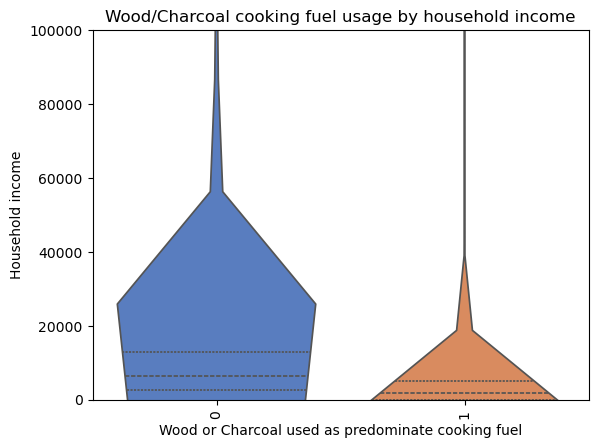

In [59]:
#violin plot to look at income vs. fuel use
sns.violinplot(x = data_HH_clean['WOOD_CHARCOAL_FUEL'], y = data_HH_clean['HHINCOME'], scale = 'count', inner = 'quartile', palette = 'muted')
plt.ylim(0, 100000)
plt.title('Wood/Charcoal cooking fuel usage by household income')
plt.xlabel('Wood or Charcoal used as predominate cooking fuel')
plt.xticks(rotation=90)
plt.ylabel('Household income')

Text(0, 0.5, 'Household income')

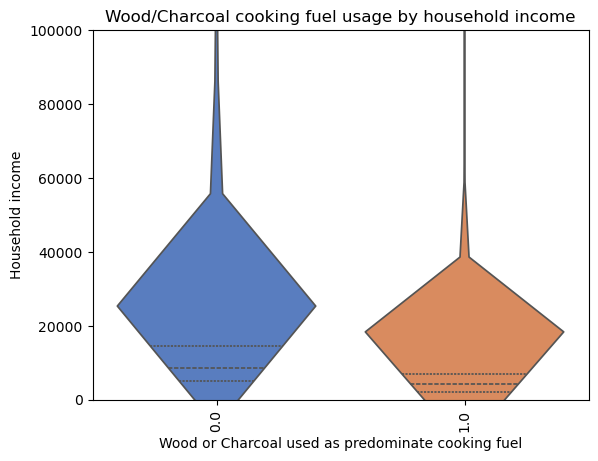

In [60]:
#violin plot to look at income vs. fuel use
data_HH_clean_income = data_HH_clean[data_HH_clean['HHINCOME'] > 0]
sns.violinplot(x = data_HH_clean_income['WOOD_CHARCOAL_FUEL'], y = data_HH_clean['HHINCOME'], scale = 'count', inner = 'quartile', palette = 'muted')
plt.ylim(0, 100000)
plt.title('Wood/Charcoal cooking fuel usage by household income')
plt.xlabel('Wood or Charcoal used as predominate cooking fuel')
plt.xticks(rotation=90)
plt.ylabel('Household income')

Clearly there is an income component to wood burning cooking. However, I need to ensure the 100K+ houses that report no income should be counted as truly having no income

In [62]:
HH_no_income_df = data_HH_clean[data_HH_clean['HHINCOME'] == 0]
HH_no_income_df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SERIAL,103982.0,NaN,NaN,NaN,1935534214.152449,1145798904.031478,136000.0,893803500.0,2075234000.0,2840500500.0,4016615000.0
PERSONS,103982.0,NaN,NaN,NaN,3.005741,1.995508,1.0,2.0,2.0,4.0,23.0
HHWT,103982.0,NaN,NaN,NaN,61.535794,118.111154,9.99,9.99,19.98,49.95,3896.1
GEO2_MX,103982.0,2325.0,484009001.0,988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNERSHIP,103982,2,Owned,86633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELECTRIC,103982,2,Yes,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATERSUPPLY,103982,3,"Piped, in home",47283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEWAGE,103982,3,Sewage system,45956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COOKINGFUEL,103982,5,"Wood, charcoal, coal, or other burned biomaterial",53384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHONE,103982,2,No,83716,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
for feature in ['OWNERSHIP','ELECTRIC','WATERSUPPLY','SEWAGE','COOKINGFUEL','PHONE','CELL','INTERNET','TRASH','NUMROOMS',
                'KITCHEN','HHTYPE','SPEAKIND','HHINCOME','ANY ILLITERACY','CHILDREN','OLDER_ADULTS','MALE_COUNT','FEMALE_COUNT']:
    print(HH_no_income_df[feature].value_counts())

OWNERSHIP
Owned        86633
Not owned    17349
Name: count, dtype: int64
ELECTRIC
Yes    100001
No       3981
Name: count, dtype: int64
WATERSUPPLY
Piped, in home     47283
Piped access       45931
No piped access    10768
Name: count, dtype: int64
SEWAGE
Sewage system    45956
Septic tank      32813
Not connected    25213
Name: count, dtype: int64
COOKINGFUEL
Wood, charcoal, coal, or other burned biomaterial    53384
Petroleum gas (NG, propane, or other)                47281
None                                                  2742
Electric                                               565
Other (solar, alcohol, etc.)                            10
Name: count, dtype: int64
PHONE
No     83716
Yes    20266
Name: count, dtype: int64
CELL
Yes    58673
No     45309
Name: count, dtype: int64
INTERNET
No     84271
Yes    19711
Name: count, dtype: int64
TRASH
Collected                     57765
Burned, burried, or dumped    46217
Name: count, dtype: int64
NUMROOMS
3.0     29852
2.0     2608

In [64]:
HH_no_income_df_retired = HH_no_income_df[HH_no_income_df['OLDER_ADULTS'] == HH_no_income_df['PERSONS']]
HH_no_income_df_retired

,SERIAL,PERSONS,HHWT,GEO2_MX,OWNERSHIP,ELECTRIC,WATERSUPPLY,SEWAGE,COOKINGFUEL,PHONE,...,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,ANY ILLITERACY,HHINCOME,STATE_NAME,WOOD_CHARCOAL_FUEL
20,206000,1,619.38,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,0,1,74.0,0,1,0,0,0.0,Aguascalientes,0
29,296000,1,599.40,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",No,...,0,1,66.0,0,1,0,0,0.0,Aguascalientes,0
37,376000,1,589.41,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,0,1,81.0,0,1,0,0,0.0,Aguascalientes,0
46,466000,2,619.38,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",Yes,...,0,2,70.5,1,1,0,0,0.0,Aguascalientes,0
47,476000,1,619.38,484001001,Not owned,Yes,"Piped, in home",Sewage system,Electric,Yes,...,0,1,64.0,0,1,0,0,0.0,Aguascalientes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402051,4016495000,1,9.99,484032004,Owned,Yes,Piped access,Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,0,1,85.0,0,1,0,1,0.0,Zacatecas,1
402059,4016575000,2,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,0,2,77.5,1,1,0,0,0.0,Zacatecas,1
402060,4016585000,2,9.99,484032004,Owned,Yes,"Piped, in home",Not connected,"Petroleum gas (NG, propane, or other)",No,...,0,2,91.5,1,1,0,0,0.0,Zacatecas,0
402061,4016595000,1,9.99,484032004,Owned,Yes,"Piped, in home",Septic tank,"Wood, charcoal, coal, or other burned biomaterial",No,...,0,1,85.0,1,0,0,0,0.0,Zacatecas,1


There are 33k households with only people aged 65 and older (retirement age in Mexico) which means these households should be kept at 0, while the others I cannot confirm if 0 income is accurate and will be removed as a comparison.

In [66]:
#Also look at the combination of Kitchen vs. cooking fuel and see if they're correlated, because then can take it out
proportion_kitchen_cookingfuel = data_HH_clean.groupby('KITCHEN')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_kitchen_cookingfuel

WOOD_CHARCOAL_FUEL,0,1
KITCHEN,,
Indoor kitchen,0.852668,0.147332
No kitchen,0.796254,0.203746
Outdoor kitchen,0.220633,0.779367


In [67]:
#Also look at the combination of indigenous language vs. cooking fuel and see if they're correlated, because then can take it out
proportion_indlang_cookingfuel = data_HH_clean.groupby('SPEAKIND')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_indlang_cookingfuel

WOOD_CHARCOAL_FUEL,0,1
SPEAKIND,,
0,0.796118,0.203882
1,0.219670,0.780330


Clearly, indigenous speaking and indigenous populations have a much higher likelihood of cooking with wood vs. gas.<br><br>
Next, I want to look at age, as it would be a theory that older generations are more likely to cook with wood than younger ones, since younger ones may be more likely to want newer services, less work, and move into more urban environments.

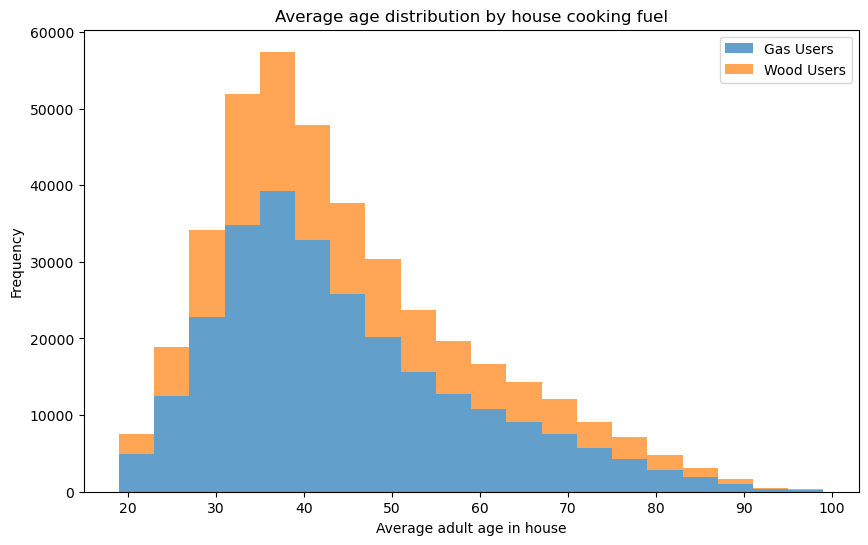

In [69]:
#also look at the distribution of age and cooking fuel, since there's a possibility that age plays a role
wood_cookers = data_HH_clean[data_HH_clean['WOOD_CHARCOAL_FUEL'] == 1]['AVG_AGE_ADULTS']
gas_cookers = data_HH_clean[data_HH_clean['WOOD_CHARCOAL_FUEL'] == 0]['AVG_AGE_ADULTS']

plt.figure(figsize = (10,6))
plt.hist([gas_cookers, wood_cookers], bins=20, stacked=True, label = ['Gas Users', 'Wood Users'], alpha = 0.7)
plt.xlabel("Average adult age in house")
plt.ylabel("Frequency")
plt.title("Average age distribution by house cooking fuel")
plt.legend()
plt.show()

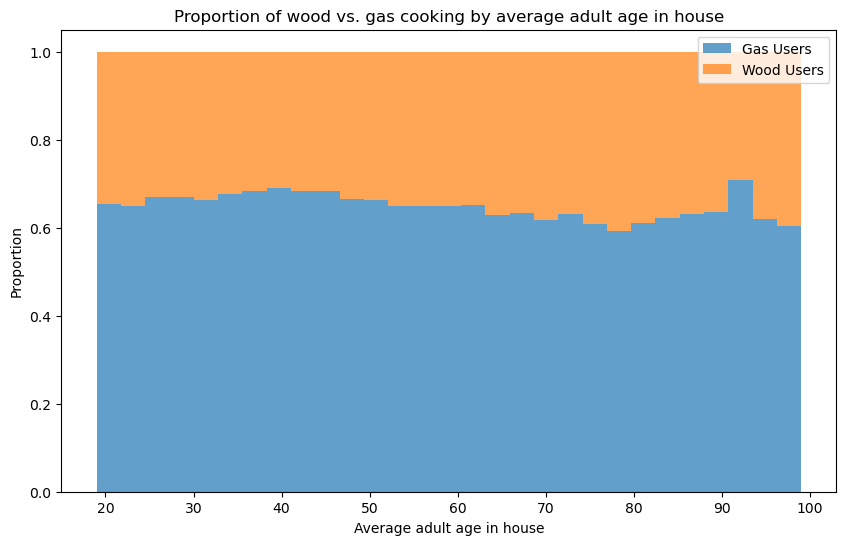

In [70]:
bins = np.linspace(min(data_HH_clean["AVG_AGE_ADULTS"]), max(data_HH_clean["AVG_AGE_ADULTS"]), 30)

# Compute histograms (density=True for proportion)
wood_hist, _ = np.histogram(wood_cookers, bins=bins)
gas_hist, _ = np.histogram(gas_cookers, bins=bins)

# Normalize to 100%
total = wood_hist + gas_hist
wood_prop = wood_hist / total
gas_prop = gas_hist / total

# Plot stacked proportion histograms
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], gas_prop, width=np.diff(bins), align="edge", label="Gas Users", alpha=0.7)
plt.bar(bins[:-1], wood_prop, width=np.diff(bins), align="edge", bottom=gas_prop, label="Wood Users", alpha=0.7)

# Labels and title
plt.xlabel("Average adult age in house")
plt.ylabel("Proportion")
plt.title("Proportion of wood vs. gas cooking by average adult age in house")
plt.legend()
plt.show()

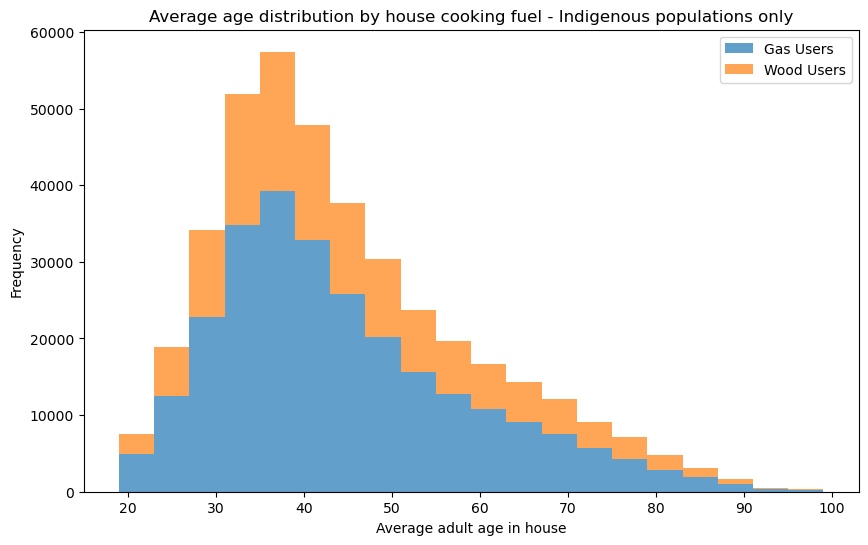

In [71]:
#now do the same with age and indigenous language
data_HH_clean_ind = data_HH_clean[data_HH_clean['SPEAKIND'] == 1]
wood_cookers_ind = data_HH_clean_ind[data_HH_clean_ind['WOOD_CHARCOAL_FUEL'] == 1]['AVG_AGE_ADULTS']
gas_cookers_ind = data_HH_clean_ind[data_HH_clean_ind['WOOD_CHARCOAL_FUEL'] == 0]['AVG_AGE_ADULTS']

plt.figure(figsize = (10,6))
plt.hist([gas_cookers, wood_cookers], bins=20, stacked=True, label = ['Gas Users', 'Wood Users'], alpha = 0.7)
plt.xlabel("Average adult age in house")
plt.ylabel("Frequency")
plt.title("Average age distribution by house cooking fuel - Indigenous populations only")
plt.legend()
plt.show()

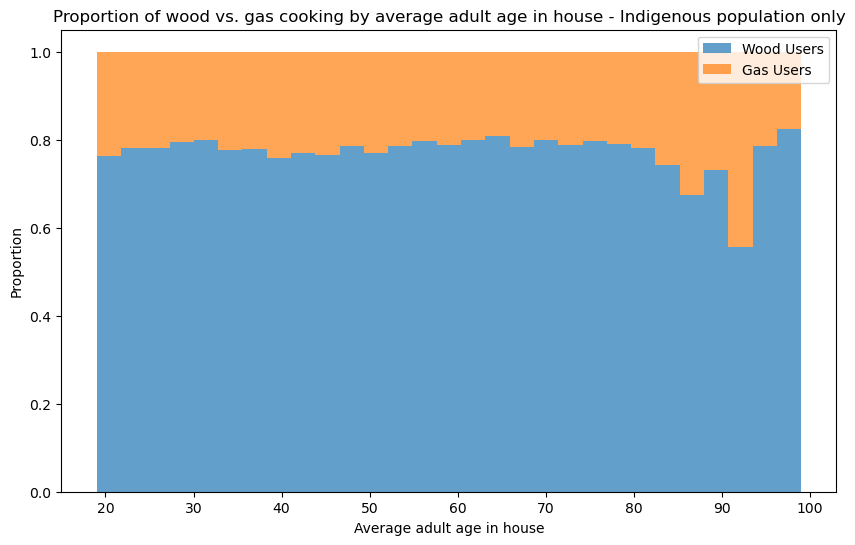

In [72]:
bins = np.linspace(min(data_HH_clean_ind["AVG_AGE_ADULTS"]), max(data_HH_clean_ind["AVG_AGE_ADULTS"]), 30)

# Compute histograms (density=True for proportion)
wood_hist_ind, _ = np.histogram(wood_cookers_ind, bins=bins)
gas_hist_ind, _ = np.histogram(gas_cookers_ind, bins=bins)

# Normalize to 100%
total_ind = wood_hist_ind + gas_hist_ind
wood_prop_ind = wood_hist_ind / total_ind
gas_prop_ind = gas_hist_ind / total_ind

# Plot stacked proportion histograms
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], wood_prop_ind, width=np.diff(bins), align="edge", label="Wood Users", alpha=0.7)
plt.bar(bins[:-1], gas_prop_ind, width=np.diff(bins), align="edge", bottom=wood_prop_ind, label="Gas Users", alpha=0.7)

# Labels and title
plt.xlabel("Average adult age in house")
plt.ylabel("Proportion")
plt.title("Proportion of wood vs. gas cooking by average adult age in house - Indigenous population only")
plt.legend()
plt.show()

Somewhat surprisingly, it doesn't appear that the age makes a huge difference. While I'd expect older populations to be more likely to cook with wood (not transitioning to a newer technology), what we see instead is a somewhat consistent use of wood vs. gas across age groups. Maybe younger generations are slightly less likely to use wood, especially for non-indigenous families, but overall, if you grew up with wood you probably likely cook with wood as well. This gives equal explanation to both a cultural aspect, as well as the obvious economic aspects being a major factor in determining wood use.

### Modeling

Modeling will start with decision trees to set a baseline, both with and without data where income is 0. From there I will do more decision trees with and without granular geographic data (GEO2_MX). Decision trees are a good baseline because they are less computationally intensive (since we have a large dataset) and will also hopefully be more interpretable. I am using accuracy as a starting point for evaluation metric because in this case there's little risk to not balancing precision vs recall. Having false positives or negatives isn't hugely detrimental, since the goal is to modernize cooking across populations. False negatives are likely worse since you're not attracting a customer that could be switching to a cleaner fuel, vs. false positives where you attempted to switch someones cooking fuel but they were already on gas or electric (the desired outcome). 

In future analysis, I will then perform logistic regression, SVC, and KNN with the higher order Mexico states, vs. more focused regions, as well as more granular data on indigenous speaking populations.

In [75]:
#create dataset with only values needed for decision tree modeling for binary classification
tree_variables = ['PERSONS', #'GEO2_MX',
        'OWNERSHIP', 'ELECTRIC',
       'WATERSUPPLY', 'SEWAGE',
        'KITCHEN','PHONE', 'CELL', 'INTERNET','TRASH', 
        'NUMROOMS', 'HHTYPE', 'NUMFAMILIES', 
        'CHILDREN','OLDER_ADULTS', 'MALE_COUNT', 'FEMALE_COUNT', 
        'SPEAKIND','ANY ILLITERACY','HHINCOME', 
        'STATE_NAME', 'WOOD_CHARCOAL_FUEL', 'AVG_AGE_ADULTS']

tree_data_starter = data_HH_clean[tree_variables].copy()

In [76]:
X = tree_data_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y = tree_data_starter['WOOD_CHARCOAL_FUEL']

In [77]:
X = pd.get_dummies(X, drop_first = True)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [79]:
#set up tree regression with max_depth of 10 just to start
tree_reg = DecisionTreeClassifier(max_depth = 10)
tree_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [80]:
#scoring on accuracy
train_acc = tree_reg.score(X_train, y_train)
test_acc = tree_reg.score(X_test, y_test)
depth_1 = tree_reg.get_depth()
print(f'Training Accuracy: {train_acc: .2f}')
print(f'Test Accuracy: {test_acc: .2f}')
print(f'Depth of tree: {depth_1}')

Training Accuracy:  0.88
Test Accuracy:  0.88
Depth of tree: 10


In [81]:
# starter_tree = plot_tree(tree_reg, feature_names = X.columns, filled = True, fontsize=5)
# plt.figure(figsize=(20,20))
# plt.savefig('First_Tree.png')

In [82]:
importances_starter = tree_reg.feature_importances_
feature_importance_tree_starter_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances_starter})
feature_importance_tree_starter_df = feature_importance_tree_starter_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_df.head(15)

,feature,importance
18,KITCHEN_Outdoor kitchen,0.599991
22,TRASH_Collected,0.163173
7,SPEAKIND,0.086403
9,HHINCOME,0.027576
16,SEWAGE_Sewage system,0.022444
20,CELL_Yes,0.015341
21,INTERNET_Yes,0.015236
0,PERSONS,0.011748
14,"WATERSUPPLY_Piped, in home",0.010980
8,ANY ILLITERACY,0.006999


In looking across all features, having an outdoor kitchen is most important for the model, while trash collected, presence of an indigenous speaker in the home, and household income are the top 4 predictors of whether a home uses wood and charcoal as primary cooking fuel. However, this doesn't tell us a very usable story. You'd assume an outdoor kitchen would be wood burning and indoor one gas burning. While we see from the earlier data cut that it's not entirely true but is a good predictor (80% of outdoor kitchens burn wood, but 15% of indoor kitchens do as well). This may be explanatory or the other way around. You have an outdoor kitchne so you burn wood...or, you burn wood so you have an outdoor kitchen. 

In [84]:
#Same trees but with no-income removed
tree_data_starter_no_income = tree_data_starter[(tree_data_starter['HHINCOME'] != 0) | (tree_data_starter['PERSONS'] == tree_data_starter['OLDER_ADULTS'])]
tree_data_starter_no_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328203 entries, 0 to 402064
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   PERSONS             328203 non-null  int64   
 1   OWNERSHIP           328203 non-null  category
 2   ELECTRIC            328203 non-null  category
 3   WATERSUPPLY         328203 non-null  category
 4   SEWAGE              328203 non-null  category
 5   KITCHEN             328203 non-null  category
 6   PHONE               328203 non-null  category
 7   CELL                328203 non-null  category
 8   INTERNET            328203 non-null  category
 9   TRASH               328203 non-null  object  
 10  NUMROOMS            328203 non-null  float64 
 11  HHTYPE              328203 non-null  category
 12  NUMFAMILIES         328203 non-null  int64   
 13  CHILDREN            328203 non-null  int64   
 14  OLDER_ADULTS        328203 non-null  int64   
 15  MALE_COUNT          32

In [85]:
X_no_inc = tree_data_starter_no_income.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_no_inc = tree_data_starter_no_income['WOOD_CHARCOAL_FUEL']

In [86]:
X_no_inc = pd.get_dummies(X_no_inc, drop_first = True)

In [87]:
X_train_ni, X_test_ni, y_train_ni, y_test_ni = train_test_split(X_no_inc, y_no_inc, test_size = 0.2)

In [88]:
#set up tree regression with max_depth of 10 just to start
tree_reg_ni = DecisionTreeClassifier(max_depth = 10)
tree_reg_ni.fit(X_train_ni, y_train_ni)

DecisionTreeClassifier(max_depth=10)

In [89]:
#scoring on accuracy
train_acc_ni = tree_reg_ni.score(X_train_ni, y_train_ni)
test_acc_ni = tree_reg_ni.score(X_test_ni, y_test_ni)
depth_1_ni = tree_reg_ni.get_depth()
print(f'Training Accuracy: {train_acc_ni: .2f}')
print(f'Test Accuracy: {test_acc_ni: .2f}')
print(f'Depth of tree: {depth_1_ni}')

Training Accuracy:  0.89
Test Accuracy:  0.88
Depth of tree: 10


In [90]:
importances_starter_ni = tree_reg_ni.feature_importances_
feature_importance_tree_starter_ni_df = pd.DataFrame({'feature': X_train_ni.columns, 'importance': importances_starter_ni})
feature_importance_tree_starter_ni_df = feature_importance_tree_starter_ni_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_ni_df

,feature,importance
18,KITCHEN_Outdoor kitchen,0.596822
22,TRASH_Collected,0.145968
7,SPEAKIND,0.090049
9,HHINCOME,0.028575
16,SEWAGE_Sewage system,0.026590
...,...,...
26,"HHTYPE_Extended family, relatives only",0.000013
51,STATE_NAME_Quintana Roo,0.000009
37,STATE_NAME_Distrito Federal,0.000000
47,STATE_NAME_Nuevo León,0.000000


When we remove the households that don't have a clear reason for having $0 income (and can therefore assume a mistake in the census process or an unwillingness to answer), given I don't have a reliable proxy for income, the models surprisingly results in nearly the exact same accuracy and feature importance. I'm not sure how to explain this other than income doesn't have much of an impact on prediction results and therefore doesn't sway much when the 70K+ households are removed from the analysis. What's likely happening is other features like trash collection, sewage system, and other utilities are likely good proxies for income to begin with, and it's possible that income doesn't have much of an impact because other variables are proxy for income.

In [92]:
#now look at the same thing where kitchen is indoor only
tree_data_starter_indoor = tree_data_starter[tree_data_starter['KITCHEN'] == 'Indoor kitchen']
tree_data_starter_indoor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272786 entries, 0 to 402063
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   PERSONS             272786 non-null  int64   
 1   OWNERSHIP           272786 non-null  category
 2   ELECTRIC            272786 non-null  category
 3   WATERSUPPLY         272786 non-null  category
 4   SEWAGE              272786 non-null  category
 5   KITCHEN             272786 non-null  category
 6   PHONE               272786 non-null  category
 7   CELL                272786 non-null  category
 8   INTERNET            272786 non-null  category
 9   TRASH               272786 non-null  object  
 10  NUMROOMS            272786 non-null  float64 
 11  HHTYPE              272786 non-null  category
 12  NUMFAMILIES         272786 non-null  int64   
 13  CHILDREN            272786 non-null  int64   
 14  OLDER_ADULTS        272786 non-null  int64   
 15  MALE_COUNT          27

In [93]:
X_indoor = tree_data_starter_indoor.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_indoor = tree_data_starter_indoor['WOOD_CHARCOAL_FUEL']
X_indoor = pd.get_dummies(X_indoor, drop_first = True)
X_train_indoor, X_test_indoor, y_train_indoor, y_test_indoor = train_test_split(X_indoor, y_indoor, test_size = 0.2)

In [94]:
tree_indoor = DecisionTreeClassifier(max_depth = 10)
tree_indoor.fit(X_train_indoor, y_train_indoor)

DecisionTreeClassifier(max_depth=10)

In [95]:
#scoring on accuracy
train_acc_indoor = tree_indoor.score(X_train_indoor, y_train_indoor)
test_acc_indoor = tree_indoor.score(X_test_indoor, y_test_indoor)
depth_1_indoor = tree_indoor.get_depth()
print(f'Training Accuracy: {train_acc_indoor: .2f}')
print(f'Test Accuracy: {test_acc_indoor: .2f}')
print(f'Depth of tree: {depth_1_indoor}')

Training Accuracy:  0.90
Test Accuracy:  0.90
Depth of tree: 10


In [96]:
importances_starter_indoor = tree_indoor.feature_importances_
feature_importance_tree_starter_indoor_df = pd.DataFrame({'feature': X_train_indoor.columns, 'importance': importances_starter_indoor})
feature_importance_tree_starter_indoor_df = feature_importance_tree_starter_indoor_df.sort_values(by='importance',ascending=False)
feature_importance_tree_starter_indoor_df

,feature,importance
22,TRASH_Collected,0.420053
7,SPEAKIND,0.216804
9,HHINCOME,0.078865
20,CELL_Yes,0.048611
14,"WATERSUPPLY_Piped, in home",0.036176
...,...,...
27,"HHTYPE_Composite household, family and non-rel...",0.000000
46,STATE_NAME_Nayarit,0.000000
45,STATE_NAME_Morelos,0.000000
37,STATE_NAME_Distrito Federal,0.000000


Finally, it is worth looking at indoor kitchens because there are particular health risks in indoor wood burning kitchens. Looking just as homes with indoor kitchens, there's even more accuracy in the decision tree model (90%) while also highlighting the importance of being on public services (trash collection, water supply) is to not using wood burning fuel. Additionally, speaking an indigenous language again shows up as the most impotant demographic feature, followed by household income. This is interesting as there is both a geographic and cultural component to wood burning cooking, and needs to be explored in more detail. 

### Revisiting the data pull ###

Now that I've seen what the most important attributes are from this sample of data, I want to do several things: <br>
-Pull new data that brings in more granularity to features like indigenous language, access to vehicles, other appliances like AC, etc. <br>
-Try new types of models like KNN, logistic regression, and SVM and combine into an ensemble model to increase test accuracy and understand feature selection even better

In [100]:
new_raw_data = pd.read_csv('Data/ipumsi_00006.csv.gz')

In [101]:
#new_raw_data.describe(include = 'all').T

In [102]:
new_data = new_raw_data.drop(columns = ['COUNTRY', 'YEAR', 'SAMPLE'])

In [103]:
#list categorical columns
categorical_new_raw = ['GEO1_MX', 'GEO2_MX', 'LOCALMX', 'OWNERSHIP','OWNERSHIPD','ELECTRIC','WATSUP','SEWAGE','FUELCOOK','PHONE','CELL',
                   'INTERNET', 'TRASH','KITCHEN','HHTYPE','SEX','SPEAKIND','LIT','HOTWATER','AIRCON','REFRIG','LANGMX']

In [104]:
for col in new_data:
    if col in categorical_new_raw:
        new_data[col] = new_data[col].astype('category')

In [105]:
new_data_categorized = new_data

#use the existing category mapping to redefine many of the same variables
new_data_categorized['STATE_NAME'] = new_data['GEO1_MX'].map(state_mapping)

#the rest of the easy to map categorical columns can be mapped here
other_new_category_mappings = {
    "OWNERSHIP": {0: "NIU", 1: "Owned", 2: "Not owned", 9: "Unknown"},
    "ELECTRIC": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "PHONE": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "CELL": {0: "NIU", 1: "Yes", 2: "No", 9: "Unknown"},
    "INTERNET": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "SEX": {1: "Male", 2: "Female", 9: "Unknown"},
    "HHTYPE": {0: "Vacant household", 1: "One-person household", 2: "Married/cohab couple, no children", 
               3: "Married/cohab couple with children", 4: "Single-parent family", 5: "Other", 
               6: "Extended family, relatives only", 7: "Other", 8: "Other", 
               9: "Other", 10: "Other", 11: "Other", 99: "Other"},
    "LIT": {0: "NIU", 1: "No, illiterate", 2: "Yes, literate", 9: "Unknown"},
    "SEWAGE": {00: "NIU", 10: "Connected to sewage system or septic", 11:"Sewage system", 12: "Septic tank", 20: "Not connected", 99: "Unknown"},
    "SPEAKIND": {0: "NIU", 1: "Yes", 2: "Yes", 3: "Yes", 4: "No", 8: "Does not speak", 9: "Unknown"},
    "HOTWATER": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"},
    "AIRCON": {0: "NIU", 10: "No", 20: "Yes", 99: "Unknown"},
    "REFRIG": {0: "NIU", 1: "No", 2: "Yes", 9: "Unknown"}
}

# Apply mappings to categorical columns
for col, mapping in other_new_category_mappings.items():
    if col in new_data.columns:
        new_data_categorized[col] = new_data[col].map(mapping)

#there are other harder to map categorical columns that must be simplified
new_data_categorized['WATSUP'] = new_data['WATSUP'].apply(map_water_type)
new_data_categorized['TRASH'] = new_data['TRASH'].apply(map_trash_type)
new_data_categorized['KITCHEN'] = new_data['KITCHEN'].apply(map_kitchen_type)
new_data_categorized['FUELCOOK'] = new_data['FUELCOOK'].apply(map_fuel_type)

#create new mapping for autos, refrig, aircon, and indigenous languages
#Autos only has 0, 7, 8, and 9
def map_autos_type(value):
    if value in [0]:
        return 'No'
    elif value in [1,2,3,4,5,6,7]:
        return 'Yes'
    elif value in [8]:
        return 'Unknown'
    elif value in [9]:
        return 'NIU'
    else:
        return 'Unknown'

new_data_categorized['AUTOS'] = new_data['AUTOS'].apply(map_autos_type)

def map_lang_type(value):
    if value in [0]:
        return 'None'
    elif value in [1012]:
        return 'Nahuatl'
    elif value in [908]:
        return 'Tzotzil'
    elif value in [413]:
        return 'Mixteco'
    elif value in [401]:
        return 'Zapoteco'
    elif value in [904]:
        return 'Maya'
    elif value in [907]:
        return 'Tzeltal'
    elif value in [423]:
        return 'Mazateco'
    elif value in [701,702]:
        return 'Totocana'
    elif value in [601]:
        return 'Tlapaneca'
    elif value in [802]:
        return 'Mixe'
    elif value in [905]:
        return 'Chol'
    elif value in [1011]:
        return 'Huichol'
    elif value in [305]:
        return 'Otomi'
    elif value in [101, 102, 103, 104, 105, 106, 107, 108]:
        return 'Hokana'
    elif value in [201, 202, 203, 204, 205, 206]:
        return 'Chinanteca'
    elif value in [301,302,303,304, 306, 307, 308]:
        return 'Other Otopame'
    elif value in [402,403,404,405,406,407,408,409,410,411,412,414,415,416,417,418,419,420,421,422,424,425,426]:
        return 'Other Oaxaquena'
    elif value in [501]:
        return 'Huave'
    elif value in [801,803,804,805,806,807,808]:
        return 'Other Mixe-zoque'
    elif value in [901,902,903,906,909,910,911,912,913,914,915,915,917,918,919,920,921]:
        return 'Other Maya'
    elif value in [1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1013,1014]:
        return 'Other Yutoazteca'
    elif value in [1101]:
        return 'Purepech'
    elif value in [1201]:
        return 'Kikapu'
    elif value in [1301,1302,1303,5001,5010,5011,5012,5020]:
        return 'Other'
    elif value in [9999]:
        return 'Unknown'

new_data_categorized['LANGMX'] = new_data['LANGMX'].apply(map_lang_type)

In [106]:
#understand the proportion of new indigenous language category 
new_data_categorized[new_data_categorized['LANGMX'] != 'None']['LANGMX'].value_counts(normalize = True)

LANGMX
Nahuatl             0.187568
Tzotzil             0.117686
Mixteco             0.105139
Zapoteco            0.092745
Maya                0.076176
Tzeltal             0.074756
Mazateco            0.047188
Totocana            0.042569
Other Yutoazteca    0.038572
Other Oaxaquena     0.034561
Tlapaneca           0.028992
Mixe                0.026251
Chol                0.022265
Chinanteca          0.017624
Otomi               0.017402
Other Mixe-zoque    0.016787
Other Maya          0.014902
Huichol             0.014884
Purepech            0.008907
Other Otopame       0.007436
Huave               0.005598
Hokana              0.001114
Unknown             0.000786
Other               0.000091
Name: proportion, dtype: float64

In [107]:
new_data_categorized['WOOD_CHARCOAL_FUEL'] = new_data_categorized['FUELCOOK'].isin(['Wood, charcoal, coal, or other burned biomaterial']).astype(int)

#Need to understand if cooking on wood is consistent across indigenous groups, and how big those indigenous groups are
proportion_lang_cookingfuel = new_data_categorized.groupby('LANGMX')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_lang_cookingfuel['Proportion of population'] = new_data_categorized['LANGMX'].value_counts(normalize=True)
proportion_lang_cookingfuel = proportion_lang_cookingfuel.sort_values(by = 1,ascending = False)
proportion_lang_cookingfuel

WOOD_CHARCOAL_FUEL,0,1,Proportion of population
LANGMX,,,
Tzeltal,0.037151,0.962849,0.013686
Huichol,0.053314,0.946686,0.002725
Tzotzil,0.053879,0.946121,0.021545
Tlapaneca,0.058255,0.941745,0.005308
Other Yutoazteca,0.066811,0.933189,0.007061
Chol,0.067190,0.932810,0.004076
Huave,0.093628,0.906372,0.001025
Chinanteca,0.104296,0.895704,0.003227
Other Oaxaquena,0.107320,0.892680,0.006327


Across the board, those that speak an indigenous language have wood burning cooking at home at a much higher rate than those that don't speak an indigenous language. And that mostly splits along 80%/20% in both directions. 80% and above cook with wood fire if speaking an indigenous language, and 20% of those that don't speak also cook with wood fire. It is worth it to then break down the data into two models. Those that speak an indigenous language, and those that do not, and from there determine what drives wood use for cooking fuel.

### Data Preparation ###

In [110]:
#to make everything more readable, relabel all columns
new_data_categorized = new_data_categorized.rename(columns = {
    'OWNERSHIPD': 'DETAILEDOWNERSHIP',
    'WATSUP': 'WATERSUPPLY',
    'FUELCOOK': 'COOKINGFUEL',
    'ROOMS': 'NUMROOMS',
    'NFAMS': 'NUMFAMILIES',
    'BPLCOUNTRY': 'BIRTHCOUNTRY',
    'LIT': 'LITERACY',
    'INCEARN': 'EARNEDINCOME',
    'POPDENSGEO2': 'LOCAL_POP_DENS'
})

In [111]:
#drop unnecessary data
new_data_household_raw = new_data_categorized.drop(columns = ['PERWT','DETAILEDOWNERSHIP','PERNUM','GEO1_MX'])

In [112]:
#use individual households to check which data is consistent and which needs to be parsed out at the household level, most noteably not everyone
#in an indigenous speaking household knows the indigenous language, nor is it always the same language
new_data_household_raw[new_data_household_raw['SERIAL'] == 3925067000].T

,1467588,1467589,1467590,1467591,1467592
SERIAL,3925067000,3925067000,3925067000,3925067000,3925067000
PERSONS,5,5,5,5,5
HHWT,29.97,29.97,29.97,29.97,29.97
LOCAL_POP_DENS,20.01,20.01,20.01,20.01,20.01
GEO2_MX,484031098,484031098,484031098,484031098,484031098
OWNERSHIP,Owned,Owned,Owned,Owned,Owned
ELECTRIC,Yes,Yes,Yes,Yes,Yes
WATERSUPPLY,Piped access,Piped access,Piped access,Piped access,Piped access
SEWAGE,Septic tank,Septic tank,Septic tank,Septic tank,Septic tank
COOKINGFUEL,"Wood, charcoal, coal, or other burned biomaterial","Wood, charcoal, coal, or other burned biomaterial","Wood, charcoal, coal, or other burned biomaterial","Wood, charcoal, coal, or other burned biomaterial","Wood, charcoal, coal, or other burned biomaterial"


In [113]:
#to understand how many indigenous households speak more than one non-spanish language
household_lang_count = new_data_household_raw[new_data_household_raw['LANGMX'] != 'None'].groupby('SERIAL')['LANGMX'].nunique()
multi_lang_houses = household_lang_count[household_lang_count > 1]
num_multi_lang_houses = len(multi_lang_houses)
num_multi_lang_houses

1365

There are only 1400 families that speak more than one indigenous language in the family, for these cases I will give a combined value of 'more than 1 indigenous language'. Since this is less than 1% of indigenous families it's not a huge difference maker

In [115]:
#number of indigenous households with a 'NIU' child
new_data_household_raw[new_data_household_raw['SPEAKIND'] == 'NIU']

,SERIAL,PERSONS,HHWT,LOCAL_POP_DENS,GEO2_MX,OWNERSHIP,ELECTRIC,WATERSUPPLY,SEWAGE,COOKINGFUEL,...,HHTYPE,NUMFAMILIES,AGE,SEX,SPEAKIND,LANGMX,LITERACY,EARNEDINCOME,STATE_NAME,WOOD_CHARCOAL_FUEL
11,26000,4,589.41,562.76001,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,2,Male,NIU,None,NIU,99999999,Aguascalientes,0
12,26000,4,589.41,562.76001,484001001,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,2,Male,NIU,None,NIU,99999999,Aguascalientes,0
36,86000,3,589.41,562.76001,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,2,Female,NIU,None,NIU,99999999,Aguascalientes,0
55,166000,4,589.41,562.76001,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,2,Female,NIU,None,NIU,99999999,Aguascalientes,0
56,166000,4,589.41,562.76001,484001001,Not owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,1,Female,NIU,None,NIU,99999999,Aguascalientes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500819,4016316000,3,9.99,9.78000,484032004,Owned,Yes,Piped access,Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,2,Male,NIU,None,NIU,99999999,Zacatecas,0
1500824,4016326000,5,9.99,9.78000,484032004,Owned,Yes,"Piped, in home",Sewage system,"Petroleum gas (NG, propane, or other)",...,Married/cohab couple with children,1,0,Female,NIU,None,NIU,99999999,Zacatecas,0
1500880,4016515000,7,9.99,9.78000,484032004,Owned,Yes,"Piped, in home",Not connected,"Petroleum gas (NG, propane, or other)",...,Other,2,1,Male,NIU,None,NIU,99999999,Zacatecas,0
1500884,4016525000,4,9.99,9.78000,484032004,Owned,Yes,Piped access,Septic tank,"Wood, charcoal, coal, or other burned biomaterial",...,Married/cohab couple with children,1,0,Female,NIU,None,NIU,99999999,Zacatecas,1


In [116]:
#first create indigenous language rules for the data aggregation
def assign_household_language(lang_series):
    unique_langs = set(lang_series) - {'None'}

    if len(unique_langs) == 0:
        return 'None'
    elif len(unique_langs) == 1:
        return unique_langs.pop()
    else:
        return 'Multiple Spoken'

#create the aggregation rules for the groupby function
new_agg_rules = {
    'PERSONS': 'first',
    'HHWT': 'first',
    'GEO2_MX': 'first',
    'OWNERSHIP': 'first',
    'ELECTRIC': 'first',
    'WATERSUPPLY': 'first',
    'SEWAGE': 'first',
    'COOKINGFUEL': 'first',
    'PHONE': 'first',
    'CELL': 'first',
    'INTERNET': 'first',
    'TRASH': 'first',
    'AUTOS': 'first',
    'HOTWATER': 'first',
    'AIRCON': 'first',
    'REFRIG': 'first',
    'NUMROOMS': 'first',
    'KITCHEN': 'first',
    'HHTYPE': 'first',
    'NUMFAMILIES': 'first',
    'LOCAL_POP_DENS': 'first',
    'AGE': [
        ('CHILDREN', lambda x: (x < 18).sum()),
        ('OLDER_ADULTS', lambda x: (x >= 60).sum()),
        #look at the average age for the population in case that is a factor in wood fuel use
        ('AVG_AGE_ADULTS', lambda x: x[(x > 18) & (x <= 100)].mean())
    ],
    'SEX': [
        ('MALE_COUNT', lambda x: (x == 'Male').sum()),
        ('FEMALE_COUNT', lambda x: (x == 'Female').sum())
    ],
    'SPEAKIND': [
        ('ANY', lambda x: 1 if (x == 'Yes').any() else 0),
        ('PERCENT', lambda x: (x == 'Yes').sum() / (x[x != 'NIU'].count()))
    ],
    'LANGMX': assign_household_language,
    'LITERACY': lambda x: 1 if (x == 'No, illiterate').any() else 0,
    'EARNEDINCOME': lambda x: 'Unknown' if (x == 99999998).all() else x[x < 99999998].sum(),
    'STATE_NAME': 'first'
}

In [117]:
new_data_HH = new_data_household_raw.groupby('SERIAL').agg(new_agg_rules).reset_index()

In [118]:
#remove the second order column names
new_data_HH.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in new_data_HH.columns]

In [119]:
new_data_HH = new_data_HH.rename(columns = {
    'PERSONS_first': 'PERSONS',
    'HHWT_first': 'HHWT',
    'NUMROOMS_first': 'NUMROOMS',
    'GEO2_MX_first': 'GEO2_MX',
    'LOCAL_POP_DENS_first': 'LOCAL_POP_DENS',
    'OWNERSHIP_first': 'OWNERSHIP',
    'WATERSUPPLY_first': 'WATERSUPPLY',
    'SEWAGE_first': 'SEWAGE',
    'COOKINGFUEL_first': 'COOKINGFUEL',
    'ELECTRIC_first': 'ELECTRIC',
    'PHONE_first': 'PHONE',
    'CELL_first': 'CELL',
    'INTERNET_first': 'INTERNET',
    'TRASH_first': 'TRASH',
    'AUTOS_first': 'AUTOS',
    'HOTWATER_first': 'HOTWATER',
    'AIRCON_first': 'AIRCON',
    'REFRIG_first': 'REFRIG',
    'KITCHEN_first': 'KITCHEN',
    'NUMFAMILIES_first': 'NUMFAMILIES',
    'HHTYPE_first': 'HHTYPE',
    'AGE_CHILDREN': 'CHILDREN',
    'AGE_OLDER_ADULTS': 'OLDER_ADULTS',
    'AGE_AVG_AGE_ADULTS': 'AVG_AGE_ADULTS',
    'SEX_MALE_COUNT': 'MALE_COUNT',
    'SEX_FEMALE_COUNT': 'FEMALE_COUNT',
    'SPEAKIND_ANY': 'SPEAKIND',
    'SPEAKIND_PERCENT': 'PROP_IND',
    'LANGMX_assign_household_language': 'LANGMX',
    'LITERACY_<lambda>': 'ANY ILLITERACY',
    'EARNEDINCOME_<lambda>': 'HHINCOME',
    'STATE_NAME_first': 'STATE_NAME'
})

In [120]:
new_data_HH['NUMROOMS'] = new_data_HH['NUMROOMS'].apply(lambda x: 'Unknown' if x > 97 else x)

In [121]:
#can now remove the Unknowns and NIU since they are both <0.5% of data in all categories
new_data_HH_clean = new_data_HH.replace(['NIU', 'Unknown'], np.nan)
new_data_HH_clean = new_data_HH_clean.dropna()

In [122]:
#check data for any imperfections or mistranslations
for feature in ['OWNERSHIP','ELECTRIC','WATERSUPPLY','SEWAGE','COOKINGFUEL','PHONE','CELL','INTERNET','TRASH',
                'NUMROOMS','KITCHEN','HHTYPE','SPEAKIND','HHINCOME','ANY ILLITERACY','CHILDREN','OLDER_ADULTS',
                'MALE_COUNT','FEMALE_COUNT','PROP_IND', 'LANGMX','STATE_NAME', 'AUTOS','HOTWATER','AIRCON','REFRIG']:
    print(new_data_HH_clean[feature].value_counts())

OWNERSHIP
Owned        304827
Not owned     93986
Name: count, dtype: int64
ELECTRIC
Yes    391430
No       7383
Name: count, dtype: int64
WATERSUPPLY
Piped, in home     228736
Piped access       142046
No piped access     28031
Name: count, dtype: int64
SEWAGE
Sewage system    232685
Septic tank      108433
Not connected     57695
Name: count, dtype: int64
COOKINGFUEL
Petroleum gas (NG, propane, or other)                254790
Wood, charcoal, coal, or other burned biomaterial    133752
None                                                   7220
Electric                                               2996
Other (solar, alcohol, etc.)                             55
Name: count, dtype: int64
PHONE
No     308975
Yes     89838
Name: count, dtype: int64
CELL
Yes    308437
No      90376
Name: count, dtype: int64
INTERNET
No     264322
Yes    134491
Name: count, dtype: int64
TRASH
Collected                     289687
Burned, burried, or dumped    109126
Name: count, dtype: int64
NUMROOMS
3.0  

At this point I have clean data at the household level and can now do more complicated modeling off this data. I will start by splitting the data into two populations: indigenous speakers, and non-indigenous speakers. I want to learn if there are different drivers between these two groups which is important because of "Two Mexicos" theory, which is the coexistance of a fast-growing, modernizing Mexican economy, with a slow moving, more traditional and agrarian economy which is often indigenous and left-behind by economic stimulus and expansion.

In [124]:
new_data_HH_clean['WOOD_CHARCOAL_FUEL'] = new_data_HH_clean['COOKINGFUEL'].isin(['Wood, charcoal, coal, or other burned biomaterial']).astype(int)

In [125]:
#create a per person income metric to try and parse out income as a factor
new_data_HH_clean['HHINCOME_PP'] = new_data_HH_clean['HHINCOME'] / new_data_HH_clean['PERSONS']

Here it's seen that 54% of indigenous homes cook with burning biomass in inside kitchens, a particular health concern, while only 9% of non-indigenous homes do. It's still a clear predictor that outdoor kitchens are much more likely to cook with wood, 93% true in indigenous homes vs. 64% in non-indigenous ones. 

Since I added 2nd level population density to the data on this analysis, I'm also curious to see how population density impacts wood fuel use

In [ ]:
density_bins = np.arange(1, 10000, 20)
new_data_HH_clean['Density_Bin'] = pd.cut(new_data_HH_clean['LOCAL_POP_DENS'], bins=density_bins)

density_stats = new_data_HH_clean.groupby('Density_Bin').agg(
    WOOD_PROPORTION = ('WOOD_CHARCOAL_FUEL', 'mean'),
    INDIGENOUS_PROPORTION = ('PROP_IND', 'mean'),
    COUNT=('LOCAL_POP_DENS', 'count')
).reset_index()

density_stats['Density_Midpoint'] = density_stats['Density_Bin'].apply(lambda x: x.mid)
plt.figure(figsize = (8,6))
scatter = plt.scatter(x=density_stats['Density_Midpoint'],
                y=density_stats['WOOD_PROPORTION'],
                c=density_stats['INDIGENOUS_PROPORTION'],
                s=density_stats['COUNT']**(0.5),
                cmap = 'plasma',
                edgecolor='black',
                alpha=0.75
               )

cbar=plt.colorbar(scatter)
cbar.set_label('Proportion speaking an indigenous language')
plt.xlabel('Local population density (ppl/km2)')
plt.ylabel('Proportion of wood burning households')
plt.title('Proportion of wood-burning cooking by population density and indigenous household proportion')
plt.xlim(0, 2100)
plt.show()

Three things stand out on this chart. 1) that not all low population density places cook on wood, in fact there's an even distirbution of gas vs. wood which means housing density is not necessarily a problem for distribution of propane tanks in rural areas. 2) Wood burning basically only exists in low population density areas. The one location where a population density of >1000 ppl/km2 has a wod burning proportion >40% is the town of Carmerino Z Mendoza in Veracruz and, unsurprinsgly, that sample in this data mostly speaks Nahuatl. 3) Indigenous populations in low density areas almost exclusively cook on wood (or at least >60%). In fact, there is higher proportion of wood cooking in indigenous speaking populations than would be predicted based solely on population density (further to the right). There's more to learn here about cultural significance, access, and economics to understand why. 

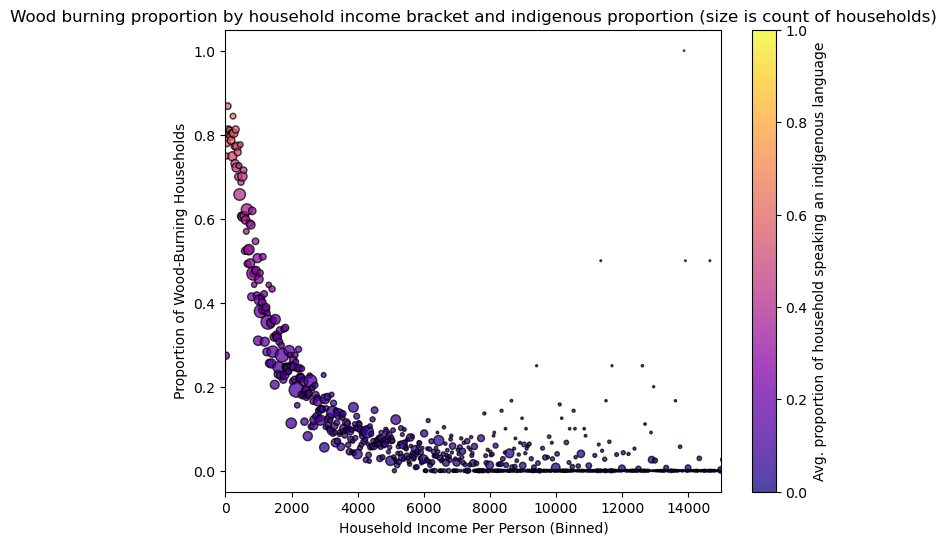

In [453]:
income_bins = np.arange(0, 100000, 20) 
new_data_HH_clean['Income_Bin'] = pd.cut(new_data_HH_clean['HHINCOME_PP'], bins=income_bins)

income_stats = new_data_HH_clean.groupby('Income_Bin').agg(
    WOOD_PROPORTION=('WOOD_CHARCOAL_FUEL', 'mean'),
    INDIGENOUS_PROPORTION=('SPEAKIND', 'mean'),
    COUNT=('HHINCOME_PP', 'count')
).reset_index()

income_stats['Income_Midpoint'] = income_stats['Income_Bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    x=income_stats['Income_Midpoint'], 
    y=income_stats['WOOD_PROPORTION'], 
    c=income_stats['INDIGENOUS_PROPORTION'], 
    cmap='plasma', 
    s = (income_stats['COUNT'])**(.5),
    edgecolor='black',
    alpha=0.75
)

cbar = plt.colorbar(scatter)
cbar.set_label('Avg. proportion of household speaking an indigenous language')
plt.xlabel('Household Income Per Person (Binned)')
plt.ylabel('Proportion of Wood-Burning Households')
plt.title('Wood burning proportion by household income bracket and indigenous proportion (size is count of households)')
plt.xlim(0, 15000)
plt.savefig('Plots/Wood_proportion_by_income.png', dpi = 300, bbox_inches ='tight')
plt.show()


Clearly there is a relationship between income and wood cooking proportion. So it's surprising that we got no difference in initial decision tree model between datasets with and without those with 0 income removed but this actually makes sense because decision trees don't weight that heavily on income. But because there is a correlation between outdoor kitchens, trash collection service, and income, we need to either remove those income = 0 data points or impute them based on avg income based on data points that have income and also have an outdoor kitchen or trash collection. We also see that indigenous speakers also tend to be lower income which could be the driver for why indigenous populations cook with wood (and not a cultural driver).

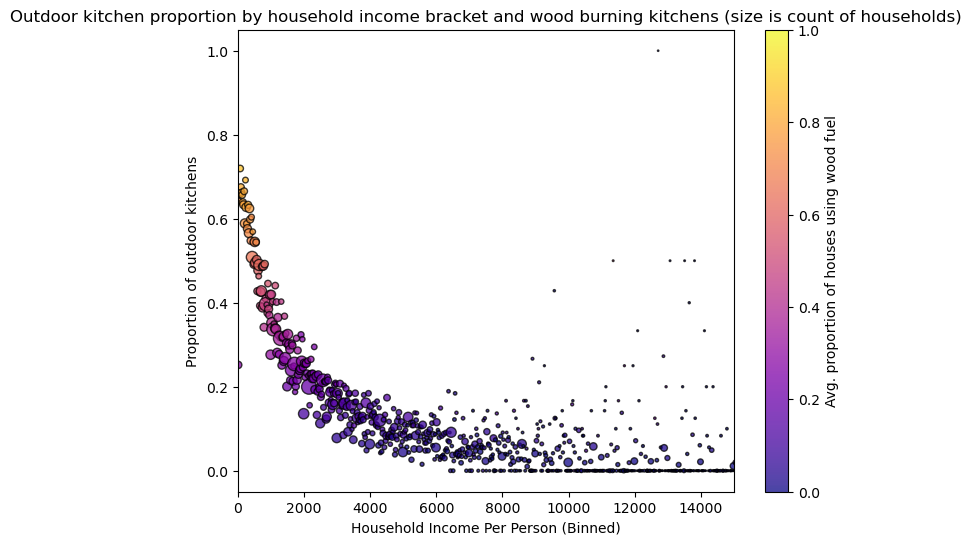

In [455]:
#check the relationship between kitchen type and income and between trash collection and income
new_data_HH_clean['KITCHEN_OUTDOOR'] = new_data_HH_clean['KITCHEN'].isin(['Outdoor kitchen']).astype(int)

income_stats_kitchen = new_data_HH_clean.groupby('Income_Bin').agg(
    KITCHEN_PROPORTION=('KITCHEN_OUTDOOR', 'mean'),
    WOOD_FUEL_PROPORTION=('WOOD_CHARCOAL_FUEL', 'mean'),
    COUNT=('HHINCOME_PP', 'count')
).reset_index()

income_stats_kitchen['Income_Midpoint'] = income_stats_kitchen['Income_Bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    x=income_stats_kitchen['Income_Midpoint'], 
    y=income_stats_kitchen['KITCHEN_PROPORTION'], 
    c=income_stats_kitchen['WOOD_FUEL_PROPORTION'], 
    cmap='plasma', 
    s = (income_stats['COUNT'])**(.5),
    edgecolor='black',
    alpha=0.75
)

cbar = plt.colorbar(scatter)
cbar.set_label('Avg. proportion of houses using wood fuel')
plt.xlabel('Household Income Per Person (Binned)')
plt.ylabel('Proportion of outdoor kitchens')
plt.title('Outdoor kitchen proportion by household income bracket and wood burning kitchens (size is count of households)')
plt.xlim(0, 15000)
plt.savefig('Plots/Outdoor_kitchen_by_income.png', dpi = 300, bbox_inches ='tight')
plt.show()


We again see a very similar trend as income to wood fueled cooking as we see in kitchens. We also see that the '0' income bucket has a much lower proportion of outdoor kitchens despite the general trend being that lower income is more likely to have outdoor kitchens.

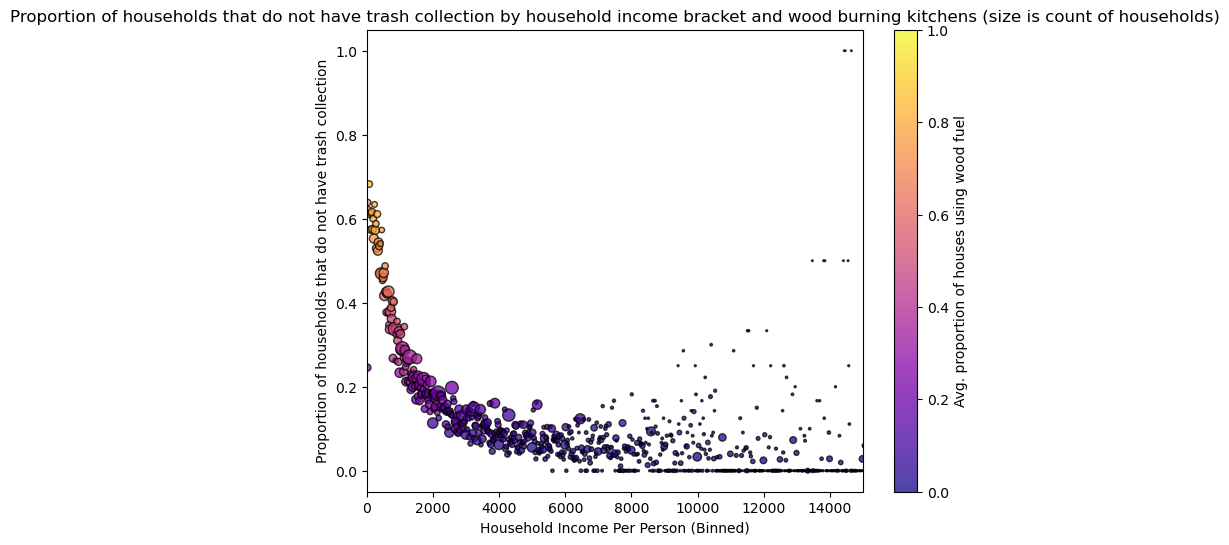

In [457]:
#one more with trash collection
new_data_HH_clean['TRASH_BURNBURYDUMP'] = new_data_HH_clean['TRASH'].isin(['Burned, burried, or dumped']).astype(int)

income_stats_trash = new_data_HH_clean.groupby('Income_Bin').agg(
    TRASH_PROPORTION=('TRASH_BURNBURYDUMP', 'mean'),
    WOOD_FUEL_PROPORTION=('WOOD_CHARCOAL_FUEL', 'mean'),
    COUNT=('HHINCOME_PP', 'count')
).reset_index()

income_stats_trash['Income_Midpoint'] = income_stats_trash['Income_Bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    x=income_stats_trash['Income_Midpoint'], 
    y=income_stats_trash['TRASH_PROPORTION'], 
    c=income_stats_trash['WOOD_FUEL_PROPORTION'], 
    cmap='plasma', 
    s = (income_stats['COUNT'])**(.5),
    edgecolor='black',
    alpha=0.75
)

cbar = plt.colorbar(scatter)
cbar.set_label('Avg. proportion of houses using wood fuel')
plt.xlabel('Household Income Per Person (Binned)')
plt.ylabel('Proportion of households that do not have trash collection')
plt.title('Proportion of households that do not have trash collection by household income bracket and wood burning kitchens (size is count of households)')
plt.xlim(0, 15000)
plt.savefig('Plots/Trash_collection_by_income.png', dpi = 300, bbox_inches ='tight')
plt.show()


We have the exact same trend across kitchen type, trash collection, and income, so clearly the relationship between income and kitchen type and trash collection is highly correlated. We also see across all three plots that the '0' income bucket is out of place from the rest of the trend. We see that incomes per person of about $6000 is required to get below 10% on all three factors (wood fuel, kitchen outdoors, and trash collection). However, income has a lower overall impact on kitchen type and trash collection. Both trash and kitchen max is around 65% of households in the lowest income brackets, while wood cooking fuel is higher than 85%.


I tried imputation based on each of the lifestyle factors to try and estimate income for each household, but didn't turn out as expected. If I'm going to drop the 0 income data points, I do I want to make sure they are representative of the entire dataset so I'm not biasing the data set.

In [137]:
new_data_HH_clean[new_data_HH_clean['HHINCOME_PP'] == 0].describe()

,SERIAL,PERSONS,HHWT,NUMROOMS,NUMFAMILIES,LOCAL_POP_DENS,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,PROP_IND,ANY ILLITERACY,HHINCOME,WOOD_CHARCOAL_FUEL,HHINCOME_PP,KITCHEN_OUTDOOR,TRASH_BURNBURYDUMP
count,1.039610e+05,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.000000,103961.00000,103961.000000,103961.0,103961.000000,103961.0,103961.000000,103961.000000
mean,1.935721e+09,3.004280,61.494797,3.212897,1.005983,395.069106,0.969883,0.758467,53.452546,1.390425,1.613855,0.351478,0.31413,0.407605,0.0,0.513394,0.0,0.423447,0.444494
std,1.145786e+09,1.995395,118.060476,1.502079,0.100321,1390.729580,1.453243,0.802993,18.078745,1.199501,1.223789,0.477434,0.44654,0.491391,0.0,0.499823,0.0,0.494107,0.496912
min,1.360000e+05,1.000000,9.990000,1.000000,1.000000,0.110000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,8.939610e+08,2.000000,9.990000,2.000000,1.000000,24.200001,0.000000,0.000000,38.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,2.075468e+09,2.000000,19.980000,3.000000,1.000000,60.150002,0.000000,1.000000,53.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.0,1.000000,0.0,0.000000,0.000000
75%,2.840543e+09,4.000000,49.950000,4.000000,1.000000,153.529999,2.000000,1.000000,68.000000,2.000000,2.000000,1.000000,1.00000,1.000000,0.0,1.000000,0.0,1.000000,1.000000
max,4.016615e+09,23.000000,3896.100000,24.000000,9.000000,10714.209961,15.000000,5.000000,100.000000,13.000000,15.000000,1.000000,1.00000,1.000000,0.0,1.000000,0.0,1.000000,1.000000


In [138]:
new_data_HH_clean[new_data_HH_clean['HHINCOME_PP'] != 0].describe()

,SERIAL,PERSONS,HHWT,NUMROOMS,NUMFAMILIES,LOCAL_POP_DENS,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,PROP_IND,ANY ILLITERACY,HHINCOME,WOOD_CHARCOAL_FUEL,HHINCOME_PP,KITCHEN_OUTDOOR,TRASH_BURNBURYDUMP
count,2.948520e+05,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,294852.000000,2.948520e+05,294852.000000,294852.000000,294852.000000,294852.000000
mean,2.034836e+09,3.998772,95.863302,3.508438,1.010928,675.050746,1.377864,0.363633,41.379853,1.969846,2.028926,0.184126,0.133681,0.258601,1.064023e+04,0.272608,3232.691941,0.250563,0.213382
std,1.162954e+09,1.958530,150.627330,1.575568,0.136737,1743.606482,1.356132,0.665672,11.577800,1.219334,1.285869,0.387588,0.312144,0.437867,2.595248e+04,0.445302,8639.199572,0.433338,0.409696
min,6.000000e+03,1.000000,9.990000,1.000000,1.000000,0.110000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.166667,0.000000,0.000000
25%,1.067714e+09,3.000000,19.980000,2.000000,1.000000,40.040001,0.000000,0.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.300000e+03,0.000000,1075.000000,0.000000,0.000000
50%,1.992092e+09,4.000000,39.960000,3.000000,1.000000,107.180000,1.000000,0.000000,39.250000,2.000000,2.000000,0.000000,0.000000,0.000000,7.000000e+03,0.000000,2000.000000,0.000000,0.000000
75%,3.067638e+09,5.000000,89.910000,4.000000,1.000000,328.489990,2.000000,1.000000,48.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.288800e+04,1.000000,3583.333333,1.000000,0.000000
max,4.016625e+09,29.000000,2497.500000,24.000000,9.000000,10714.209961,16.000000,7.000000,99.000000,18.000000,16.000000,1.000000,1.000000,1.000000,3.000000e+06,1.000000,1000000.000000,1.000000,1.000000


The no income group is not representative of the overall sample, so there are certainly households in this dataset that truly have no income. It almost certainly isn't a quarter of households but things like retirees and households that are potentially seasonal or make income elsewhere and is remitted.

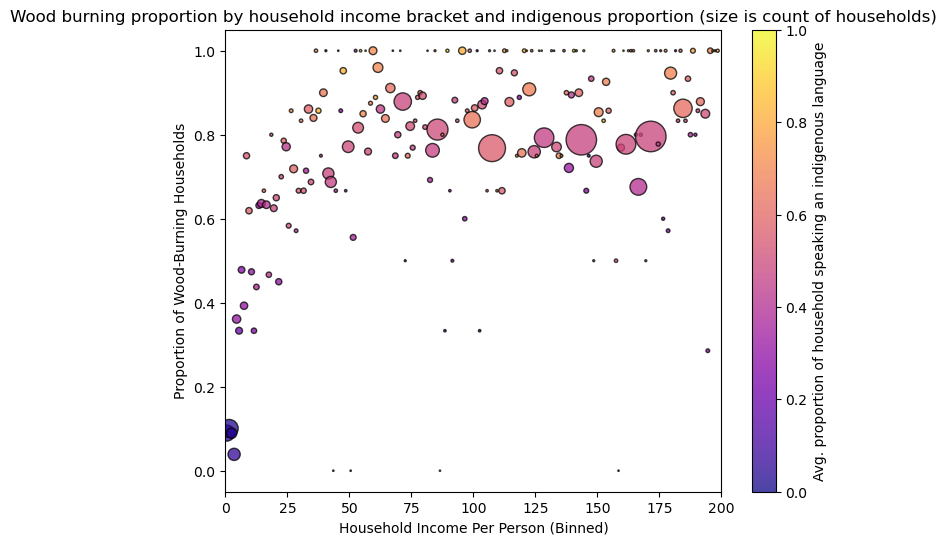

In [140]:
#plot the income vs. wood cooking but narrow in around the '0' income edge and see if there's any discrepency
income_bins = np.arange(0, 200, 1) 
new_data_HH_clean['Income_Bin'] = pd.cut(new_data_HH_clean['HHINCOME_PP'], bins=income_bins)

income_stats = new_data_HH_clean.groupby('Income_Bin').agg(
    WOOD_PROPORTION=('WOOD_CHARCOAL_FUEL', 'mean'),
    INDIGENOUS_PROPORTION=('PROP_IND', 'mean'),
    COUNT=('HHINCOME_PP', 'count')
).reset_index()

income_stats['Income_Midpoint'] = income_stats['Income_Bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    x=income_stats['Income_Midpoint'], 
    y=income_stats['WOOD_PROPORTION'], 
    c=income_stats['INDIGENOUS_PROPORTION'], 
    cmap='plasma', 
    s = income_stats['COUNT'],
    edgecolor='black',
    alpha=0.75
)

cbar = plt.colorbar(scatter)
cbar.set_label('Avg. proportion of household speaking an indigenous language')
plt.xlabel('Household Income Per Person (Binned)')
plt.ylabel('Proportion of Wood-Burning Households')
plt.title('Wood burning proportion by household income bracket and indigenous proportion (size is count of households)')
plt.xlim(0, 200)
plt.show()

Now I can see that there are outliers at household incomes below 25 dollars per person and especially below 10 dollars (this is also true for outdoor kitchens and trash collection). My guess is these are income numbers that were reported but missing 1, 2, or 3 0s. Rather than try and guess where these data points should be, I will just eliminate them from the data. 

In [142]:
new_data_HH_final = new_data_HH_clean[(new_data_HH_clean['HHINCOME_PP'] > 25) | (new_data_HH_clean['HHINCOME_PP'] == 0)]

In [143]:
#create datasets that separate out indigenous and non-indigenous
data_HH_indigenous = new_data_HH_final[new_data_HH_clean['LANGMX'] != 'None']
data_HH_nonindigenous = new_data_HH_final[new_data_HH_clean['LANGMX'] == 'None']

In [144]:
data_HH_indigenous.describe()

,SERIAL,PERSONS,HHWT,NUMROOMS,NUMFAMILIES,LOCAL_POP_DENS,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,PROP_IND,ANY ILLITERACY,HHINCOME,WOOD_CHARCOAL_FUEL,HHINCOME_PP,KITCHEN_OUTDOOR,TRASH_BURNBURYDUMP
count,9.061800e+04,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.0,90618.000000,90618.000000,9.061800e+04,90618.000000,90618.000000,90618.000000,90618.000000
mean,2.086674e+09,4.186254,33.613200,2.941557,1.007228,203.658542,1.620583,0.504999,44.582497,2.023583,2.162672,1.0,0.793223,0.538635,3.986549e+03,0.780794,1018.753750,0.624523,0.592311
std,1.189296e+09,2.311106,71.412383,1.400241,0.114609,701.953140,1.678585,0.748116,15.062983,1.398806,1.423070,0.0,0.293079,0.498508,1.489379e+04,0.413711,2883.390475,0.484249,0.491408
min,7.050000e+05,1.000000,9.990000,1.000000,1.000000,0.450000,0.000000,0.000000,19.000000,0.000000,0.000000,1.0,0.047619,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,9.586985e+08,2.000000,9.990000,2.000000,1.000000,33.509998,0.000000,0.000000,33.500000,1.000000,1.000000,1.0,0.500000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,2.292356e+09,4.000000,9.990000,3.000000,1.000000,70.680000,1.000000,0.000000,41.000000,2.000000,2.000000,1.0,1.000000,1.000000,1.720000e+03,1.000000,430.000000,1.000000,1.000000
75%,2.891748e+09,5.000000,29.970000,4.000000,1.000000,163.070007,3.000000,1.000000,53.400000,3.000000,3.000000,1.0,1.000000,1.000000,5.160000e+03,1.000000,1326.857143,1.000000,1.000000
max,4.013798e+09,27.000000,2497.500000,20.000000,9.000000,10714.209961,15.000000,5.000000,100.000000,14.000000,16.000000,1.0,1.000000,1.000000,3.000000e+06,1.000000,500000.000000,1.000000,1.000000


In [145]:
data_HH_nonindigenous.describe()

,SERIAL,PERSONS,HHWT,NUMROOMS,NUMFAMILIES,LOCAL_POP_DENS,CHILDREN,OLDER_ADULTS,AVG_AGE_ADULTS,MALE_COUNT,FEMALE_COUNT,SPEAKIND,PROP_IND,ANY ILLITERACY,HHINCOME,WOOD_CHARCOAL_FUEL,HHINCOME_PP,KITCHEN_OUTDOOR,TRASH_BURNBURYDUMP
count,3.073260e+05,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.000000,307326.0,307326.0,307326.000000,3.073260e+05,307326.000000,307326.000000,307326.000000,307326.000000
mean,1.986957e+09,3.607131,102.453719,3.574673,1.010334,716.856135,1.168063,0.455305,44.513602,1.758117,1.849014,0.0,0.0,0.226401,9.032786e+03,0.204083,2801.069071,0.198669,0.179633
std,1.149350e+09,1.900076,155.122849,1.577671,0.131930,1832.649022,1.278607,0.717733,14.433385,1.183077,1.229143,0.0,0.0,0.418502,2.455868e+04,0.403031,8427.875357,0.398999,0.383882
min,6.000000e+03,1.000000,9.990000,1.000000,1.000000,0.110000,0.000000,0.000000,19.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.047610e+09,2.000000,19.980000,3.000000,1.000000,34.639999,0.000000,0.000000,34.000000,1.000000,1.000000,0.0,0.0,0.000000,1.667000e+03,0.000000,430.000000,0.000000,0.000000
50%,1.873915e+09,3.000000,39.960000,3.000000,1.000000,99.500000,1.000000,0.000000,41.000000,2.000000,2.000000,0.0,0.0,0.000000,6.000000e+03,0.000000,1686.000000,0.000000,0.000000
75%,3.051458e+09,5.000000,99.900000,4.000000,1.000000,346.380005,2.000000,1.000000,53.000000,2.000000,3.000000,0.0,0.0,0.000000,1.143800e+04,0.000000,3250.000000,0.000000,0.000000
max,4.016625e+09,29.000000,3896.100000,24.000000,9.000000,10714.209961,16.000000,7.000000,100.000000,18.000000,16.000000,0.0,0.0,1.000000,3.000000e+06,1.000000,1000000.000000,1.000000,1.000000


Just looking at the descriptive statistics, it appears there tend to be more individuals, living in a smaller household, with more children and more retired aged adults in each house, while each house on average has less rooms in indigenous households, which are more often located in less dense localities (rural), and have half the income on average. Next I'll look at the split of cooking with wood vs. types of kitchens. 78% of indigenous speaking households cook wiht wood, while only 20% of non-indigenous speaking households do.

In [147]:
proportion_kitchen_cookingfuel_indigenous = data_HH_indigenous.groupby('KITCHEN')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_kitchen_cookingfuel_indigenous

WOOD_CHARCOAL_FUEL,0,1
KITCHEN,,
Indoor kitchen,0.454710,0.545290
No kitchen,0.656346,0.343654
Outdoor kitchen,0.068295,0.931705


In [148]:
proportion_kitchen_cookingfuel_nonindigenous = data_HH_nonindigenous.groupby('KITCHEN')['WOOD_CHARCOAL_FUEL'].value_counts(normalize=True).unstack()
proportion_kitchen_cookingfuel_nonindigenous

WOOD_CHARCOAL_FUEL,0,1
KITCHEN,,
Indoor kitchen,0.904410,0.095590
No kitchen,0.860726,0.139274
Outdoor kitchen,0.362389,0.637611


### Modeling, revisited

Plan is to start with the basic decision tree modeling, as I did with the previous dataset, in order to compare the two separate datasets to the baseline. After decision trees have been created, I will also try to get more accurate models using various ensemble techniques as well as GridSearch for ideal hyperparamaters.

In [150]:
#create dataset with only values needed for decision tree modeling for binary classification
tree_variables_new = ['PERSONS', 
        'LOCAL_POP_DENS',#'GEO2_MX',
        'OWNERSHIP', 'ELECTRIC','WATERSUPPLY','SEWAGE',
        'KITCHEN','PHONE', 'CELL', 'INTERNET','TRASH', 
        'NUMROOMS', 'HHTYPE', 'NUMFAMILIES','CHILDREN','OLDER_ADULTS', 'MALE_COUNT', 'FEMALE_COUNT',
        'ANY ILLITERACY','HHINCOME','HHINCOME_PP','AVG_AGE_ADULTS','LANGMX','PROP_IND', 
        'WOOD_CHARCOAL_FUEL','HOTWATER','STATE_NAME','AUTOS','REFRIG','AIRCON'
]

tree_indig_starter = data_HH_indigenous[tree_variables_new].copy()
tree_nonindig_starter = data_HH_nonindigenous[tree_variables_new].copy()
tree_combined_starter = new_data_HH_final[tree_variables_new].copy()

In [151]:
X_ind = tree_indig_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_ind = tree_indig_starter['WOOD_CHARCOAL_FUEL']
X_nonind = tree_nonindig_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_nonind = tree_nonindig_starter['WOOD_CHARCOAL_FUEL']
X_com = tree_combined_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y_com = tree_combined_starter['WOOD_CHARCOAL_FUEL']
X_ind = pd.get_dummies(X_ind, drop_first = True)
X_nonind = pd.get_dummies(X_nonind, drop_first = True)
X_com = pd.get_dummies(X_com, drop_first = True)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_ind, y_ind, test_size = 0.2)
Xni_train, Xni_test, yni_train, yni_test = train_test_split(X_nonind, y_nonind, test_size = 0.2)
X_com_train, X_com_test, y_com_train, y_com_test = train_test_split(X_com, y_com, test_size = 0.2)

In [152]:
tree_ind = DecisionTreeClassifier(max_depth = 9)
tree_ind.fit(Xi_train, yi_train)
tree_nonind = DecisionTreeClassifier(max_depth = 9)
tree_nonind.fit(Xni_train, yni_train)
tree_com = DecisionTreeClassifier(max_depth = 9)
tree_com.fit(X_com_train, y_com_train)

DecisionTreeClassifier(max_depth=9)

In [153]:
#scoring on accuracy
train_acc_ind = tree_ind.score(Xi_train, yi_train)
test_acc_ind = tree_ind.score(Xi_test, yi_test)
print(f'Training Accuracy indigenous: {train_acc_ind: .2f}')
print(f'Test Accuracy indigenous: {test_acc_ind: .2f}')

Training Accuracy indigenous:  0.89
Test Accuracy indigenous:  0.88


In [154]:
#scoring on accuracy
train_acc_nonind = tree_nonind.score(Xni_train, yni_train)
test_acc_nonind = tree_nonind.score(Xni_test, yni_test)
print(f'Training Accuracy non-indigenous: {train_acc_nonind: .2f}')
print(f'Test Accuracy non-indigenous: {test_acc_nonind: .2f}')

Training Accuracy non-indigenous:  0.89
Test Accuracy non-indigenous:  0.88


In [155]:
#scoring on accuracy
train_acc_com = tree_com.score(X_com_train, y_com_train)
test_acc_com = tree_com.score(X_com_test, y_com_test)
print(f'Training Accuracy combined: {train_acc_com: .2f}')
print(f'Test Accuracy combined: {test_acc_com: .2f}')

Training Accuracy combined:  0.89
Test Accuracy combined:  0.88


There is high accuracy right off the bat with decision trees for all data sets, now I want to see what the most important factors are for each

In [157]:
tree_importances_ind = tree_ind.feature_importances_
feature_importance_tree_ind_df = pd.DataFrame({'indigenous feature': Xi_train.columns, 'importance to indigenous tree': tree_importances_ind})
feature_importance_tree_ind_df = feature_importance_tree_ind_df.sort_values(by='importance to indigenous tree',ascending=False)
feature_importance_tree_ind_df.head(10)

,indigenous feature,importance to indigenous tree
20,KITCHEN_Outdoor kitchen,0.407284
24,TRASH_Collected,0.187444
10,HHINCOME_PP,0.118414
12,PROP_IND,0.050522
19,KITCHEN_No kitchen,0.039703
86,REFRIG_Yes,0.033696
53,HOTWATER_Yes,0.032693
1,LOCAL_POP_DENS,0.025076
18,SEWAGE_Sewage system,0.013274
0,PERSONS,0.010819


In [158]:
tree_importances_nonind = tree_nonind.feature_importances_
feature_importance_tree_nonind_df = pd.DataFrame({'non-indigenous feature': Xni_train.columns, 'importance to non-indigenous tree': tree_importances_nonind})
feature_importance_tree_nonind_df = feature_importance_tree_nonind_df.sort_values(by='importance to non-indigenous tree',ascending=False)
feature_importance_tree_nonind_df.head(10)

,non-indigenous feature,importance to non-indigenous tree
20,KITCHEN_Outdoor kitchen,0.580574
24,TRASH_Collected,0.115253
18,SEWAGE_Sewage system,0.094087
10,HHINCOME_PP,0.051344
30,HOTWATER_Yes,0.037993
1,LOCAL_POP_DENS,0.025409
63,REFRIG_Yes,0.024785
23,INTERNET_Yes,0.013582
22,CELL_Yes,0.009749
19,KITCHEN_No kitchen,0.007360


In [159]:
tree_importances_com = tree_com.feature_importances_
feature_importance_tree_com_df = pd.DataFrame({'combined feature': X_com_train.columns, 'importance to combined tree': tree_importances_com})
feature_importance_tree_com_df = feature_importance_tree_com_df.sort_values(by='importance to combined tree',ascending=False)
feature_importance_tree_com_df.head(10)

,combined feature,importance to combined tree
20,KITCHEN_Outdoor kitchen,0.594840
24,TRASH_Collected,0.162536
12,PROP_IND,0.091880
10,HHINCOME_PP,0.036650
54,HOTWATER_Yes,0.025977
18,SEWAGE_Sewage system,0.021349
87,REFRIG_Yes,0.015545
1,LOCAL_POP_DENS,0.011388
19,KITCHEN_No kitchen,0.009357
23,INTERNET_Yes,0.006487


Overall, the top three factors for each group varies slightly. For indigenous households it's outdoor kitchen, trash collection, and income per person. For non-ingidengous households, it's outoodr kitchen, trash collection, and sewer connection before income. Granted, trash collection and sewer connection may just be proxies for income. 

At this point, I want to look at the relationship of trash collection and kitchen type to income to ensure there isn't co-linear relationships there and we're not obscuring the driver of wood burning kitchens. 

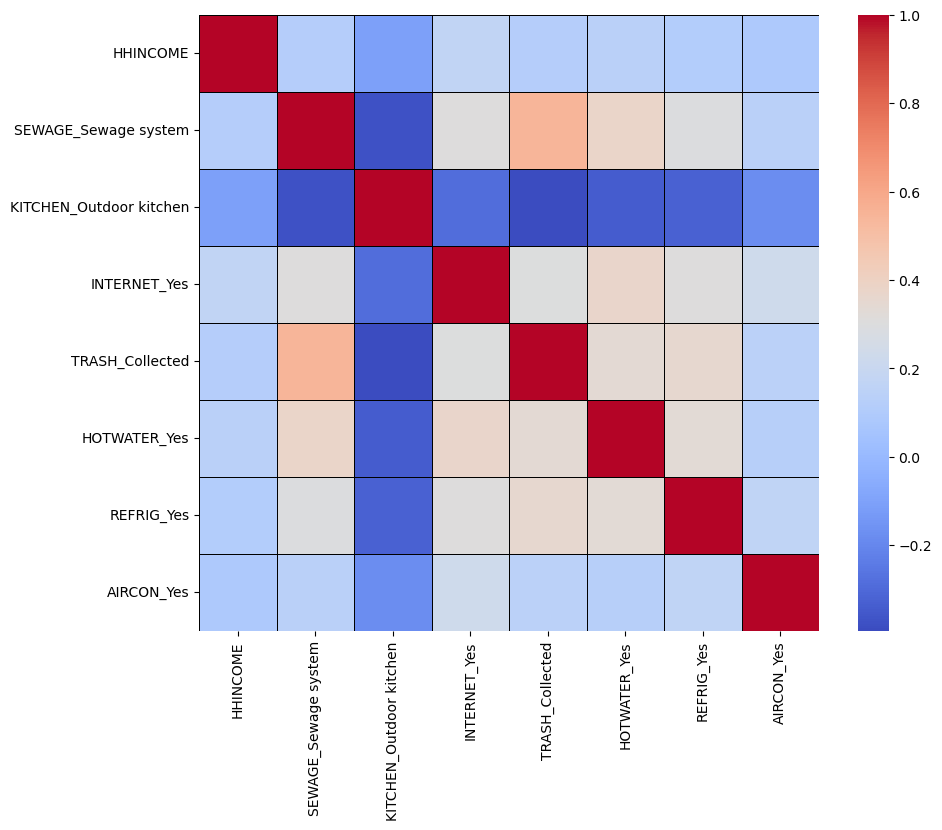

In [162]:
services_corr_vars = ['HHINCOME','SEWAGE_Sewage system','KITCHEN_Outdoor kitchen', 'INTERNET_Yes','TRASH_Collected','HOTWATER_Yes','REFRIG_Yes','AIRCON_Yes']
services_corr = X_com[services_corr_vars].copy()
services_corr = services_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(services_corr,annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black',
            xticklabels=services_corr.columns, yticklabels=services_corr.columns)
plt.show()

Lots of variables are correlated somewhat with each other, like if you're on public services like sewer, you probably are also on other public services like trash collection, have hotwater, and have internet. Interestingly, outdoor kitchens are negatively correlated with these public services, and especially with trash collection. Also interesting, none of these are correlated that strongly with income, suggesting it's more a factor of where you live than what you make. Because of how one-hot encoding is operating, outdoor kitchen is kept instead of indoor meaning negative correlation. 

### Ensemble Modeling

In [430]:
#create dataset with only values needed for knn modeling for binary classification
variables = [
        'LOCAL_POP_DENS','WATERSUPPLY','SEWAGE',
        'KITCHEN','PHONE', 'CELL', 'INTERNET','TRASH', 
        'NUMROOMS','NUMFAMILIES','CHILDREN','OLDER_ADULTS', 'MALE_COUNT','FEMALE_COUNT',
        'ANY ILLITERACY','HHINCOME_PP',
        'AVG_AGE_ADULTS',#'LANGMX', remove specific indigenous languages because wasn't getting more accurate but was slowing down modeling
        'PROP_IND','WOOD_CHARCOAL_FUEL','HOTWATER','REFRIG','HHTYPE'
]

#set sample sizes because of taxing modeling for KNN and SVC
sample_starter = new_data_HH_final[variables].sample(n=20000)
#did not see any difference in accuracy between full data and 100K homes sample, but did reduce computation
full_starter = new_data_HH_final[variables].sample(n=100000) 

In [431]:
Xs = sample_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
ys = sample_starter['WOOD_CHARCOAL_FUEL']
Xs = pd.get_dummies(Xs, drop_first = True)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size = 0.2)

In [434]:
X = full_starter.drop(columns = ['WOOD_CHARCOAL_FUEL'])
y = full_starter['WOOD_CHARCOAL_FUEL']
X = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Different classification models may offer different results or rely on different features of the data for classification. I will approach ensemble modeling through two lenses - random forests and ensemble models with KNN, trees, SVC, and logistic regression

In [436]:
#first try existing datasets with random forests
rf = RandomForestClassifier(n_estimators=100, max_depth=12, max_features='sqrt', min_samples_split=10)
rf.fit(X_train, y_train)
rf_train_acc = rf.score(X_train, y_train)
rf_test_acc = rf.score(X_test, y_test)
print(f'Random forest training accuracy: {rf_train_acc: .2f}')
print(f'Random forest test accuracy: {rf_test_acc: .2f}')

Random forest training accuracy:  0.91
Random forest test accuracy:  0.89


In [309]:
feature_importance_rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})

feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importance',ascending=False)
feature_importance_rf_df

,Feature,Importance
16,KITCHEN_Outdoor kitchen,0.235260
10,PROP_IND,0.142266
20,TRASH_Collected,0.099749
14,SEWAGE_Sewage system,0.080121
8,HHINCOME_PP,0.063986
0,LOCAL_POP_DENS,0.051753
12,"WATERSUPPLY_Piped, in home",0.044997
22,REFRIG_Yes,0.038057
21,HOTWATER_Yes,0.034793
9,AVG_AGE_ADULTS,0.034130


Random forest doesn't make much of an impact on overall model accuracy compared to single decision trees (but is slightly better). This makes sense because there are very few deciding factors that make the model go towards wood burning or gas cooking. NOTE: I also tried this with removing many of the features and the results were still identical between single trees and random forests. 

In [311]:
#also try with AdaBoost
Ada = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
Ada_train_acc = Ada.score(X_train, y_train)
Ada_test_acc = Ada.score(X_test, y_test)
print(f'AdaBoost training accuracy: {Ada_train_acc: .2f}')
print(f'AdaBoost test accuracy: {Ada_test_acc: .2f}')

AdaBoost training accuracy:  0.88
AdaBoost test accuracy:  0.88


In [313]:
feature_importance_ada_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': Ada.feature_importances_
})

feature_importance_ada_df = feature_importance_ada_df.sort_values(by='Importance',ascending=False)
feature_importance_ada_df

,Feature,Importance
0,LOCAL_POP_DENS,0.29
8,HHINCOME_PP,0.15
9,AVG_AGE_ADULTS,0.08
10,PROP_IND,0.08
3,CHILDREN,0.05
1,NUMROOMS,0.04
5,MALE_COUNT,0.04
19,INTERNET_Yes,0.03
16,KITCHEN_Outdoor kitchen,0.03
21,HOTWATER_Yes,0.02


AdaBoost is another variation on tree classifiers and exhibits slightly improved testing accuracy as well. Interestingly, AdaBoost shows several other features as important that is different to trees and forests, such as population density. So far, AdaBoost and random forests have done the best. But I'm still interested in understanding how different ensemble models will do. Particuarly KNN.

In [389]:
#knn with pipeline
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 9))])
knn_pipe.fit(Xs_train, ys_train)
knn_train_preds = knn_pipe.predict(Xs_train)
knn_test_preds = knn_pipe.predict(Xs_test)
knn_train_acc = accuracy_score(ys_train, knn_train_preds)
knn_test_acc = accuracy_score(ys_test, knn_test_preds)
print(f'KNN training accuracy: {knn_train_acc: .2f}')
print(f'KNN test accuracy: {knn_test_acc: .2f}')

KNN training accuracy:  0.89
KNN test accuracy:  0.87


In [391]:
knn_perm = permutation_importance(knn_pipe, Xs_test, ys_test, n_repeats = 3, random_state = 42, n_jobs=-1)
knn_importances = knn_perm.importances_mean
knn_importances_df = pd.DataFrame({'Feature': Xs.columns, 'Importance': knn_importances})
knn_importances_df = knn_importances_df.sort_values(by='Importance', ascending=False)
knn_importances_df

,Feature,Importance
16,KITCHEN_Outdoor kitchen,0.043500
10,PROP_IND,0.019750
20,TRASH_Collected,0.016667
15,KITCHEN_No kitchen,0.006667
18,CELL_Yes,0.006417
22,REFRIG_Yes,0.006000
0,LOCAL_POP_DENS,0.005917
13,SEWAGE_Septic tank,0.004417
19,INTERNET_Yes,0.003833
7,ANY ILLITERACY,0.002833


Compared to decision trees, KNN slightly less accurate, with similar feature importance (outdoor kitchen, indigenous speaking, and trash collection), but doesn't highlight income as important at all which is very interesting. KNN also doesn't improve much with accuracy with many neighbors and makes computational time really expensive, I could not get accuracy above 0.87 even with 100 neighbors and more.

Next I will also try logistic regresion for prediction

In [410]:
#logistic regression with pipeline
lgr_pipe = Pipeline([('scale', StandardScaler()), ('lgr', LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 1000))])
lgr_pipe.fit(X_train, y_train)
lgr_train_preds = lgr_pipe.predict(X_train)
lgr_test_preds = lgr_pipe.predict(X_test)
lgr_train_acc = accuracy_score(y_train, lgr_train_preds)
lgr_test_acc = accuracy_score(y_test, lgr_test_preds)
print(f'Logistic regression training accuracy: {lgr_train_acc: .2f}')
print(f'Logistic regression test accuracy: {lgr_test_acc: .2f}')

Logistic regression training accuracy:  0.88
Logistic regression test accuracy:  0.88


In [399]:
# Extract the trained logistic regression model from the pipeline
logistic_model = lgr_pipe.named_steps['lgr']
lgr_feature_names = X_train.columns
lgr_feature_importances = np.abs(logistic_model.coef_[0])
lgr_importance_df = pd.DataFrame({'Feature': lgr_feature_names, 'Coeff': logistic_model.coef_[0], 'Importance': lgr_feature_importances})
lgr_importance_df = lgr_importance_df.sort_values(by='Importance', ascending=False)
lgr_importance_df

,Feature,Coeff,Importance
8,HHINCOME_PP,-1.817963,1.817963
0,LOCAL_POP_DENS,-1.342302,1.342302
16,KITCHEN_Outdoor kitchen,0.815326,0.815326
10,PROP_IND,0.625620,0.625620
14,SEWAGE_Sewage system,-0.463698,0.463698
21,HOTWATER_Yes,-0.402823,0.402823
20,TRASH_Collected,-0.394747,0.394747
22,REFRIG_Yes,-0.362497,0.362497
5,MALE_COUNT,0.322222,0.322222
3,CHILDREN,-0.292444,0.292444


This is interesting because the logistic model gets a very similar accuracy score to decision trees and boosted trees, while highlighting different feature importances. Here, income and population density are most important, followed by outdoor kitchen and indigenous language speaking. There is significantly more weighting to income and density than to the other two features, which didn't pop as much in the previous models but is something you'd expect. This really highlights how different models are getting to the answer in different ways. KNN puts almost no importance on income, while in logistic regression it's the most important. This means there must be some colinearity happening if two models get to the same accuracy in two different ways

In [438]:
lgr_poly_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 1000))
])
lgr_poly_pipe.fit(X_train, y_train)
lgr_train_preds_poly = lgr_poly_pipe.predict(X_train)
lgr_test_preds_poly = lgr_poly_pipe.predict(X_test)
lgr_poly_train_acc = accuracy_score(y_train, lgr_train_preds_poly)
lgr_poly_test_acc = accuracy_score(y_test, lgr_test_preds_poly)
print(f'Logistic regression (poly) training accuracy: {lgr_poly_train_acc: .2f}')
print(f'Logistic regression (poly) test accuracy: {lgr_poly_test_acc: .2f}')

Logistic regression (poly) training accuracy:  0.89
Logistic regression (poly) test accuracy:  0.89


In [335]:
#get feature importances from polynomial logistic regression
poly = lgr_poly_pipe.named_steps['poly']
poly_feature_names = poly.get_feature_names_out(input_features=X.columns)
poly_steps = lgr_poly_pipe.named_steps['lgr']
lgr_poly_coefs = poly_steps.coef_[0]
lgr_poly_feature_importance = pd.DataFrame({'Feature': poly_feature_names, 'Coefficient': lgr_poly_coefs})
lgr_poly_feature_importance['Absolute Coefficient'] = lgr_poly_feature_importance['Coefficient'].abs()
lgr_poly_feature_importance = lgr_poly_feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
lgr_poly_feature_importance.head(15)

,Feature,Coefficient,Absolute Coefficient
28,LOCAL_POP_DENS^2,1.121817,1.121817
8,HHINCOME_PP,-0.880797,0.880797
0,LOCAL_POP_DENS,-0.868911,0.868911
29,LOCAL_POP_DENS NUMROOMS,-0.823091,0.823091
237,HHINCOME_PP HOTWATER_Yes,0.790255,0.790255
230,HHINCOME_PP SEWAGE_Sewage system,-0.665380,0.665380
4,OLDER_ADULTS,0.650429,0.650429
89,NUMFAMILIES HHINCOME_PP,-0.627322,0.627322
115,CHILDREN AVG_AGE_ADULTS,0.598711,0.598711
30,LOCAL_POP_DENS NUMFAMILIES,-0.588456,0.588456


Polynomial logistic regression of degree 2 does offer some more complex interactions and gets us slightly better on accuracy than simple logistic regression and highlights many of the same features around income and population density. We've met the accuracy of our other models. 

Lastly, I'm going to run an individual support vector (SVC) model

In [413]:
#finally, try SVC
svc_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
])
svc_pipe.fit(Xs_train, ys_train)
svc_train_preds = svc_pipe.predict(Xs_train)
svc_test_preds = svc_pipe.predict(Xs_test)
svc_train_acc = accuracy_score(ys_train, svc_train_preds)
svc_test_acc = accuracy_score(ys_test, svc_test_preds)
print(f'Support Vector training accuracy: {svc_train_acc: .2f}')
print(f'Support Vector test accuracy: {svc_test_acc: .2f}')

Support Vector training accuracy:  0.90
Support Vector test accuracy:  0.88


In [222]:
svc_perm = permutation_importance(svc_pipe, Xs_test, ys_test, scoring = 'accuracy')
svc_importances_df = pd.DataFrame({'Feature': Xs_train.columns, 'Importance': svc_perm.importances_mean})
svc_importances_df = svc_importances_df.sort_values(by='Importance', ascending=False)
svc_importances_df

,Feature,Importance
16,KITCHEN_Outdoor kitchen,0.04855
10,PROP_IND,0.02505
0,LOCAL_POP_DENS,0.00685
15,KITCHEN_No kitchen,0.00630
20,TRASH_Collected,0.00590
14,SEWAGE_Sewage system,0.00445
8,HHINCOME_PP,0.00425
22,REFRIG_Yes,0.00400
21,HOTWATER_Yes,0.00370
6,FEMALE_COUNT,0.00140


SVC has similar results to KNN where income doesn't have a big impact on predicting wood fueled cooking, but outdoor kitchen, trash collection, and indigenous languages do. This makes sense since SVC and KNN are both distance based algorithms that will tend to fit into groupings, which income doesn't neatly fit into.

Now I am going to build the ensemble model to hopefully predict with higher accuracy, since some models are better at predicting on income and population density, and others on kitchen type and indigenous speaking. I've chosen to use three models that use different ways to approximate - trees based on entropy, logistic regression based on non-linear fit of features, and support vectors based on distance (and had higher accuracy than KNN). 

In [415]:
#create voting classifier
voting_clf = VotingClassifier(estimators=[
    ('tree', tree_com),
    ('rf', rf),
    ('ada', Ada),
    ('log_reg', lgr_pipe),
    ('log_reg_poly', lgr_poly_pipe)
], voting = 'hard')

voting_clf.fit(X_train, y_train)
y_pred_vote_train = voting_clf.predict(X_train)
y_pred_vote_test = voting_clf.predict(X_test)
ensemble_train_acc = accuracy_score(y_train, y_pred_vote_train)
ensemble_test_acc = accuracy_score(y_test, y_pred_vote_test)
print(f'Ensemble training accuracy: {ensemble_train_acc: .2f}')
print(f'Ensemble test accuracy: {ensemble_test_acc: .2f}')

Ensemble training accuracy:  0.89
Ensemble test accuracy:  0.89


From the ensemble model, we don't really have any improvement in accuracy, and we've just made our modeling more complicated. Because of this, I can say that random forest and polynomial logistic regression are the most accurate models. Since they have the same accuracy we should choose the best model based on F-1 score.

In [440]:
#F1 score to tiebreak the two best models. Better F1 score means better balance between recall and precision
lgr_poly_f1 = f1_score(y_test, lgr_test_preds_poly)
rf_test_preds = rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_test_preds)
print(f'Polynomial Logistic Regression F1 score: {lgr_poly_f1: .2f}')
print(f'Random forest F1 score: {rf_f1: .2f}')

Polynomial Logistic Regression F1 score:  0.82
Random forest F1 score:  0.83


Random forest F1 score is slightly better (and accuracy is also 0.001 better), making it our preferred model for determining which households cook with wood, charcoal, or other solid biofuels. 